In [1]:
#Install required modules

!pip install segmentation-models-pytorch
!pip install albumentations
!pip install opencv-python-headless

  Using cached segmentation_models_pytorch-0.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached segmentation_models_pytorch-0.5.0-py3-none-any.whl (154 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x8

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, Input, Concatenate
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import MeanIoU

2025-11-26 02:35:14.292294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764124514.477367     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764124514.530319     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Create the base data frame for the data. IF you have multiple files you will need to change base directory.
import os
import pandas as pd
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
def Create_Directory_DataFrame(typ='train', dataset_type='idrid'):
    """
    Create DataFrame for either IDRiD or DDR dataset
    """
    rows = []
    
    if dataset_type == 'idrid':
        # IDRiD dataset structure
        basedir = '/kaggle/input/indian-diabetic-retinopathy-image-dataset/A.%20Segmentation/A. Segmentation/1. Original Images/'
        
        for Class in os.listdir(basedir):
            for location in os.listdir(os.path.join(basedir, Class)):
                if location.endswith('.jpg'):
                    class_split = Class.split(' ')
                    class_name = class_split[1] if len(class_split) > 1 else class_split[0]
                    
                    rows.append({
                        'Dataset': 'idrid',
                        'Class': class_name,
                        'Location': os.path.join(basedir, Class, location),
                        'ID': location.split('.')[0].split('_')[1] if '_' in location else location.split('.')[0],
                        'Type': 'train'  # IDRiD doesn't have separate validation, we'll split it
                    })
    
    elif dataset_type == 'ddr':
        # DDR dataset structure - fixed the f-string issue
        basedir = f"/kaggle/input/ddr-segmentation/lesion_segmentation/{typ}/"
        image_dir = os.path.join(basedir, 'image')
        
        if not os.path.exists(image_dir):
            print(f"Warning: DDR {typ} image directory not found: {image_dir}")
            return pd.DataFrame(rows)
        
        # Get all JPEG images
        for img_path in glob(os.path.join(image_dir, '*.jpg')):
            img_name = os.path.basename(img_path)
            img_id = img_name.split('.')[0]  # Remove .jpeg extension
            
            rows.append({
                'Dataset': 'ddr',
                'Class': 'DR',  # DDR doesn't have separate classes for images
                'Location': img_path,
                'ID': img_id,
                'Type': typ
            })
    
    df = pd.DataFrame(rows)
    if len(df) > 0:
        df = df.sample(frac=1).reset_index(drop=True)
    return df

def Create_Directory_Array(typ='train', dataset_type='idrid'):
    """
    Create mask DataFrame for either IDRiD or DDR dataset
    """
    rows = []
    
    if dataset_type == 'idrid':
        # IDRiD mask structure
        basedir = '/kaggle/input/indian-diabetic-retinopathy-image-dataset/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/'
        
        for Class in os.listdir(basedir):
            class_path = os.path.join(basedir, Class)
            
            if os.path.isdir(class_path):
                class_parts = Class.split(' ')
                class_label = class_parts[1] if len(class_parts) > 1 else class_parts[0]
                
                for subclass in os.listdir(class_path):
                    subclass_path = os.path.join(class_path, subclass)
                    
                    if os.path.isdir(subclass_path):
                        for location in os.listdir(subclass_path):
                            if location.endswith('.tif'):
                                rows.append({
                                    'Dataset': 'idrid',
                                    'Class': class_label,
                                    'SubClass': subclass,
                                    'Location': os.path.join(subclass_path, location),
                                    'ID': location.split('.')[0].split('_')[1] if '_' in location else location.split('.')[0],
                                    'Type': 'train'
                                })
    
    elif dataset_type == 'ddr':
        # DDR mask structure - now supports both train and validation
        basedir = f"/kaggle/input/ddr-segmentation/lesion_segmentation/{typ}/label/"
        if typ == 'valid':
            basedir = f"/kaggle/input/ddr-segmentation/lesion_segmentation/{typ}/segmentation label/"
        
        if not os.path.exists(basedir):
            print(f"Warning: DDR {typ} label directory not found: {basedir}")
            return rows
            
        lesion_types = ['MA', 'EX', 'HE', 'SE']  # Microaneurysms, Exudates, Haemorrhages, Soft Exudates
        
        for lesion_type in lesion_types:
            lesion_dir = os.path.join(basedir, lesion_type)
            if not os.path.exists(lesion_dir):
                print(f"Warning: DDR {typ} lesion directory not found: {lesion_dir}")
                continue
                
            for mask_path in glob(os.path.join(lesion_dir, '*.tif')):
                mask_name = os.path.basename(mask_path)
                mask_id = mask_name.split('.')[0]  # Remove .tif extension
                
                # Map DDR lesion types to our standard class names
                class_mapping = {
                    'MA': 'Microaneurysms',
                    'EX': 'Hard Exudates', 
                    'HE': 'Haemorrhages',
                    'SE': 'Soft Exudates'
                }
                
                rows.append({
                    'Dataset': 'ddr',
                    'Class': class_mapping[lesion_type],
                    'SubClass': class_mapping[lesion_type],
                    'Location': mask_path,
                    'ID': mask_id,
                    'Type': typ
                })
    
    return rows

# Let's debug step by step
print("=== Creating DataFrames ===")

# Create DataFrames for both datasets and both types
print("Creating IDRiD original DataFrame...")
df_original_idrid = Create_Directory_DataFrame('train', 'idrid')
print(f"IDRiD original shape: {df_original_idrid.shape}")

print("\nCreating DDR train original DataFrame...")
df_original_ddr_train = Create_Directory_DataFrame('train', 'ddr')
print(f"DDR train original shape: {df_original_ddr_train.shape}")

print("\nCreating DDR validation original DataFrame...")
df_original_ddr_val = Create_Directory_DataFrame('valid', 'ddr')
print(f"DDR validation original shape: {df_original_ddr_val.shape}")

# Create mask DataFrames for both datasets and both types
print("\nCreating IDRiD mask array...")
mask_array_idrid = Create_Directory_Array('train', 'idrid')
df_mask_idrid = pd.DataFrame(mask_array_idrid)
print(f"IDRiD mask shape: {df_mask_idrid.shape}")

print("\nCreating DDR train mask array...")
mask_array_ddr_train = Create_Directory_Array('train', 'ddr')
df_mask_ddr_train = pd.DataFrame(mask_array_ddr_train)
print(f"DDR train mask shape: {df_mask_ddr_train.shape}")

print("\nCreating DDR validation mask array...")
mask_array_ddr_val = Create_Directory_Array('valid', 'ddr')
df_mask_ddr_val = pd.DataFrame(mask_array_ddr_val)
print(f"DDR validation mask shape: {df_mask_ddr_val.shape}")

# Merge function for any dataset and type
def merge_datasets(original_df, mask_df, dataset_name):
    """Helper function to merge original and mask dataframes"""
    if len(original_df) > 0 and len(mask_df) > 0 and 'ID' in original_df.columns and 'ID' in mask_df.columns:
        print(f"Merging {dataset_name} data...")
        joined = pd.merge(original_df, mask_df, on='ID', suffixes=('_img', '_mask'))
        joined = joined.rename(columns={
            'Location_img': 'ImagePath',
            'Location_mask': 'MaskPath', 
            'Class_img': 'ImageClass',
            'Class_mask': 'MaskClass',
            'Dataset_img': 'Dataset',
            'Type_img': 'Type'
        })
        # Keep only necessary columns
        joined = joined[['ID', 'ImagePath', 'MaskPath', 'SubClass', 'Dataset', 'MaskClass', 'Type']]
        
        # Clean subclass for IDRiD if needed
        if dataset_name == 'IDRiD':
            # Clean IDRiD subclass names
            joined['SubClassClean'] = joined['SubClass'].apply(
                lambda x: x.split('. ')[1].strip() if '. ' in str(x) else str(x)
            )
        else:
            # DDR already clean
            joined['SubClassClean'] = joined['SubClass']
        
        print(f"Joined {dataset_name} shape: {joined.shape}")
        return joined
    else:
        print(f"Skipping {dataset_name} merge - missing data or ID column")
        return pd.DataFrame()

print("\n=== Merging DataFrames ===")

# Merge all datasets
joined_idrid = merge_datasets(df_original_idrid, df_mask_idrid, 'IDRiD')
joined_ddr_train = merge_datasets(df_original_ddr_train, df_mask_ddr_train, 'DDR Train')
joined_ddr_val = merge_datasets(df_original_ddr_val, df_mask_ddr_val, 'DDR Validation')

# Combine all datasets
all_datasets = []
if len(joined_idrid) > 0:
    all_datasets.append(joined_idrid)
if len(joined_ddr_train) > 0:
    all_datasets.append(joined_ddr_train)
if len(joined_ddr_val) > 0:
    all_datasets.append(joined_ddr_val)

if all_datasets:
    combined_df = pd.concat(all_datasets, ignore_index=True)
    print(f"\nCombined dataset shape: {combined_df.shape}")
    
    # Show distribution by dataset and type
    print("\nDataset distribution:")
    print(combined_df.groupby(['Dataset', 'Type']).size())
    
    print("\nClass distribution:")
    print(combined_df['MaskClass'].value_counts())
else:
    combined_df = pd.DataFrame()
    print("No datasets were successfully merged")

print("\n=== Final DataFrames ===")
print(f"Combined dataset: {combined_df.shape if len(combined_df) > 0 else 'Empty'}")

# Save the datasets
if len(joined_idrid) > 0:
    joined_idrid.to_csv('joined_idrid.csv', index=False)
    print("Saved joined_idrid.csv")

if len(joined_ddr_train) > 0:
    joined_ddr_train.to_csv('joined_ddr_train.csv', index=False)
    print("Saved joined_ddr_train.csv")

if len(joined_ddr_val) > 0:
    joined_ddr_val.to_csv('joined_ddr_val.csv', index=False)
    print("Saved joined_ddr_val.csv")

if len(combined_df) > 0:
    combined_df.to_csv('combined_dataset.csv', index=False)
    print("Saved combined_dataset.csv")

# Now create train/val splits properly
def create_final_splits(combined_df, test_size=0.3, random_state=42):
    """
    Create proper train/validation splits considering the existing splits
    """
    # For IDRiD, we need to split since it doesn't have predefined validation
    idrid_data = combined_df[combined_df['Dataset'] == 'idrid']
    ddr_train = combined_df[(combined_df['Dataset'] == 'ddr') & (combined_df['Type'] == 'train')]
    ddr_val = combined_df[(combined_df['Dataset'] == 'ddr') & (combined_df['Type'] == 'validation')]
    
    print(f"\nCreating final splits:")
    print(f"IDRiD data: {len(idrid_data['ID'].unique())} images")
    print(f"DDR train: {len(ddr_train['ID'].unique())} images") 
    print(f"DDR validation: {len(ddr_val['ID'].unique())} images")
    
    # Split IDRiD into train/val
    idrid_ids = idrid_data['ID'].unique()
    idrid_train_ids, idrid_val_ids = train_test_split(
        idrid_ids, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    # Create final DataFrames
    train_df = pd.concat([
        idrid_data[idrid_data['ID'].isin(idrid_train_ids)],
        ddr_train
    ], ignore_index=True)
    
    val_df = pd.concat([
        idrid_data[idrid_data['ID'].isin(idrid_val_ids)],
        ddr_val
    ], ignore_index=True)
    
    print(f"\nFinal splits:")
    print(f"Training: {len(train_df['ID'].unique())} images")
    print(f"Validation: {len(val_df['ID'].unique())} images")
    
    return train_df, val_df

# Create final splits
if len(combined_df) > 0:
    train_df, val_df = create_final_splits(combined_df)
    
    # Save the final splits
    train_df.to_csv('final_train_dataset.csv', index=False)
    val_df.to_csv('final_val_dataset.csv', index=False)
    print("\nSaved final_train_dataset.csv and final_val_dataset.csv")

=== Creating DataFrames ===
Creating IDRiD original DataFrame...
IDRiD original shape: (81, 5)

Creating DDR train original DataFrame...
DDR train original shape: (383, 5)

Creating DDR validation original DataFrame...
DDR validation original shape: (149, 5)

Creating IDRiD mask array...
IDRiD mask shape: (363, 6)

Creating DDR train mask array...
DDR train mask shape: (1532, 6)

Creating DDR validation mask array...
DDR validation mask shape: (596, 6)

=== Merging DataFrames ===
Merging IDRiD data...
Joined IDRiD shape: (363, 8)
Merging DDR Train data...
Joined DDR Train shape: (1532, 8)
Merging DDR Validation data...
Joined DDR Validation shape: (596, 8)

Combined dataset shape: (2491, 8)

Dataset distribution:
Dataset  Type 
ddr      train    1532
         valid     596
idrid    train     363
dtype: int64

Class distribution:
MaskClass
Hard Exudates     532
Microaneurysms    532
Haemorrhages      532
Soft Exudates     532
Training          241
Testing           122
Name: count, dtyp

In [4]:
#Just for visualization
import cv2

# Define class colors (same as earlier)
CLASS_COLORS = {
    "MA": (0, 0, 255),    # Red
    "HE": (0, 255, 0),    # Green
    "EX": (255, 0, 0),    # Blue
    "SE": (255, 255, 0),  # Cyan
    "OD": (255, 0, 255)   # Magenta
}

CLASS_NAMES = ["MA", "HE", "EX", "SE", "OD"]

In [5]:
def rgb_to_class(mask_rgb):
    """
    Convert an RGB mask image to integer mask with class IDs.
    
    Args:
        mask_rgb (np.array): HxWx3 RGB mask
    Returns:
        mask_class (np.array): HxW integer mask (0=background, 1=MA, 2=HE, etc.)
    """
    mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)  # initialize background = 0
    for idx, class_name in enumerate(CLASS_NAMES, start=1):  # IDs start at 1
        color = CLASS_COLORS[class_name]
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = idx
    return mask_class

Defines a function named Create_Directory_Array, which is used to read metadata of TIFF image files from a specified directory structure (including class label, subclass name, full file path, and an ID extracted from the filename). These pieces of information are stored as a list of dictionaries. The list is then converted into a Pandas DataFrame, the rows of the DataFrame are randomly shuffled, and finally the DataFrame is saved as a CSV file.

Prints the shape of the saved dataset and displays the first 20 rows for inspection.

Performs a grouped count (aggregation) based on the class type.

In [6]:
#Wow look the data is so cool amirite
print(train_df.shape)
train_df.head(20)

(1785, 8)


ID                                          ImagePath  \
0   04  /kaggle/input/indian-diabetic-retinopathy-imag...   
1   04  /kaggle/input/indian-diabetic-retinopathy-imag...   
2   04  /kaggle/input/indian-diabetic-retinopathy-imag...   
3   04  /kaggle/input/indian-diabetic-retinopathy-imag...   
4   48  /kaggle/input/indian-diabetic-retinopathy-imag...   
5   48  /kaggle/input/indian-diabetic-retinopathy-imag...   
6   48  /kaggle/input/indian-diabetic-retinopathy-imag...   
7   48  /kaggle/input/indian-diabetic-retinopathy-imag...   
8   48  /kaggle/input/indian-diabetic-retinopathy-imag...   
9   13  /kaggle/input/indian-diabetic-retinopathy-imag...   
10  13  /kaggle/input/indian-diabetic-retinopathy-imag...   
11  13  /kaggle/input/indian-diabetic-retinopathy-imag...   
12  13  /kaggle/input/indian-diabetic-retinopathy-imag...   
13  13  /kaggle/input/indian-diabetic-retinopathy-imag...   
14  52  /kaggle/input/indian-diabetic-retinopathy-imag...   
15  52  /kaggle/input/indian-diabetic-retinopathy-imag...   
16  52  /kaggle/input/indian-diabetic-retinopathy-imag...   
17  52  /kaggle/input/indian-diabetic-retinopathy-imag...   
18  52  /kaggle/input/indian-diabetic-retinopathy-imag...   
19  66  /kaggle/input/indian-diabetic-retinopathy-imag...   

                                             MaskPath           SubClass  \
0   /kaggle/input/indian-diabetic-retinopathy-imag...   3. Hard Exudates   
1   /kaggle/input/indian-diabetic-retinopathy-imag...    2. Haemorrhages   
2   /kaggle/input/indian-diabetic-retinopathy-imag...  1. Microaneurysms   
3   /kaggle/input/indian-diabetic-retinopathy-imag...      5. Optic Disc   
4   /kaggle/input/indian-diabetic-retinopathy-imag...   3. Hard Exudates   
5   /kaggle/input/indian-diabetic-retinopathy-imag...    2. Haemorrhages   
6   /kaggle/input/indian-diabetic-retinopathy-imag...  1. Microaneurysms   
7   /kaggle/input/indian-diabetic-retinopathy-imag...      5. Optic Disc   
8   /kaggle/input/indian-diabetic-retinopathy-imag...   4. Soft Exudates   
9   /kaggle/input/indian-diabetic-retinopathy-imag...   3. Hard Exudates   
10  /kaggle/input/indian-diabetic-retinopathy-imag...    2. Haemorrhages   
11  /kaggle/input/indian-diabetic-retinopathy-imag...  1. Microaneurysms   
12  /kaggle/input/indian-diabetic-retinopathy-imag...      5. Optic Disc   
13  /kaggle/input/indian-diabetic-retinopathy-imag...   4. Soft Exudates   
14  /kaggle/input/indian-diabetic-retinopathy-imag...   3. Hard Exudates   
15  /kaggle/input/indian-diabetic-retinopathy-imag...    2. Haemorrhages   
16  /kaggle/input/indian-diabetic-retinopathy-imag...  1. Microaneurysms   
17  /kaggle/input/indian-diabetic-retinopathy-imag...      5. Optic Disc   
18  /kaggle/input/indian-diabetic-retinopathy-imag...   4. Soft Exudates   
19  /kaggle/input/indian-diabetic-retinopathy-imag...   3. Hard Exudates   

   Dataset MaskClass   Type   SubClassClean  
0    idrid  Training  train   Hard Exudates  
1    idrid  Training  train    Haemorrhages  
2    idrid  Training  train  Microaneurysms  
3    idrid  Training  train      Optic Disc  
4    idrid  Training  train   Hard Exudates  
5    idrid  Training  train    Haemorrhages  
6    idrid  Training  train  Microaneurysms  
7    idrid  Training  train      Optic Disc  
8    idrid  Training  train   Soft Exudates  
9    idrid  Training  train   Hard Exudates  
10   idrid  Training  train    Haemorrhages  
11   idrid  Training  train  Microaneurysms  
12   idrid  Training  train      Optic Disc  
13   idrid  Training  train   Soft Exudates  
14   idrid  Training  train   Hard Exudates  
15   idrid  Training  train    Haemorrhages  
16   idrid  Training  train  Microaneurysms  
17   idrid  Training  train      Optic Disc  
18   idrid  Training  train   Soft Exudates  
19   idrid   Testing  train   Hard Exudates

In [7]:
#Now we got the REAL class names
CLASS_NAMES = ["Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates"]
n_classes = len(CLASS_NAMES)

In [8]:

train_df[train_df['SubClassClean'].isna()]

Empty DataFrame
Columns: [ID, ImagePath, MaskPath, SubClass, Dataset, MaskClass, Type, SubClassClean]
Index: []

In [9]:
#PRetty self explanatory if u dont get it just slam it into chatgpt

def load_mask(mask_path, subclass_name, size=(512,512)):

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask_class = np.zeros(mask.shape, dtype=np.uint8)
    if np.max(mask) > 0:
        class_id = CLASS_NAMES.index(subclass_name) + 1  # 1-based class ID
        mask_class[mask > 0] = class_id
        
    mask_class = np.expand_dims(mask_class, axis=-1)
    return mask_class

In [10]:
#Same as above

def load_img(image_path, size=(512,512)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    img = img.astype(np.float32) / 255.0
    return img

In [11]:
#This one combines the masks so we can overlay onto the image(The masks are stored as seperate images)

def combine_masks(df_group, size=(512,512)):
    combined_mask = np.zeros((size[1], size[0], 1), dtype=np.uint8)
    for _, row in df_group.iterrows():
        if row['SubClassClean'] == "Optic Disc":
            continue
        single_mask = load_mask(row['MaskPath'], row['SubClassClean'], size=size)
        combined_mask = np.maximum(combined_mask, single_mask)
    return combined_mask

In [12]:
#Load... the data?

def load_data(joined_df, size=(512,512)):
    images = []
    masks = []
    #Find all images by id
    grouped = joined_df.groupby('ID')
    for img_id, group in grouped:
        # Load image
        image_path = group['ImagePath'].iloc[0]  # all rows have same image path
        images.append(load_img(image_path, size=size))
        
        # Combine all masks for this image
        masks.append(combine_masks(group, size=size))
        
    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

In [13]:
X, Y = load_data(train_df)
print("Images shape:", X.shape)
print("Masks shape:", Y.shape)

Images shape: (439, 512, 512, 3)
Masks shape: (439, 512, 512, 1)


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define class colors and names
CLASS_INFO = {
    1: ("Microaneurysms", (255, 0, 0)),      # Red
    2: ("Haemorrhages", (0, 255, 0)),        # Green
    3: ("Hard Exudates", (0, 0, 255)),       # Blue
    4: ("Soft Exudates", (255, 255, 0)),     # Yellow 
}

#Wow so much work just to see a couple eyeball pics 
#I generated this whole function with chatgpt
def visualize_image_with_mask(image, mask):
    """
    image: numpy array (H,W,3), float32 [0,1] RGB
    mask: numpy array (H,W,1), uint8 class IDs (0 = background)
    """
    mask = mask.squeeze()
    overlay = np.zeros_like(image, dtype=np.uint8)

    # Build overlay per class
    for class_id, (_, color) in CLASS_INFO.items():
        overlay[mask == class_id] = color

    # Display side by side
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.imshow(overlay, alpha=0.5)
    plt.title("Image with Mask Overlay")
    plt.axis('off')

    # Legend patches
    patches = [mpatches.Patch(color=np.array(color)/255.0, label=name) 
               for _, (name, color) in CLASS_INFO.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

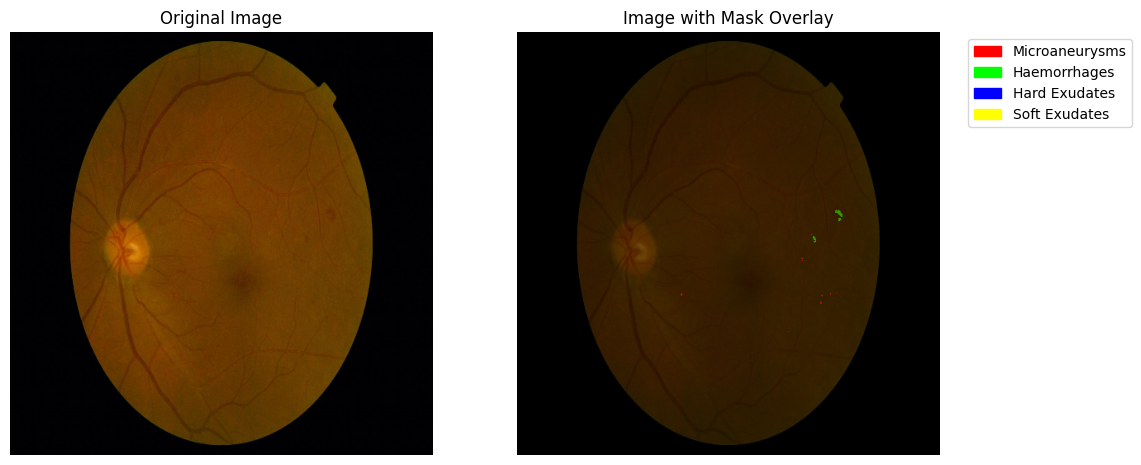

In [15]:
# Pick a sample from the loaded dataset
sample_idx = 10
visualize_image_with_mask(X[sample_idx], Y[sample_idx])

In [16]:
#Import torch
import torch
import numpy as np

#We have to prepare our datasets for pytorch.
#Why not combine the other function with this one? -some nerd
def prepare_for_pytorch(X, Y):
    # X: (N, H, W, 3) -> (N, 3, H, W)
    X_torch = np.transpose(X, (0, 3, 1, 2)).astype(np.float32)
    
    # Y: (N, H, W, 1) -> (N, H, W), dtype long
    Y_torch = Y.squeeze(-1).astype(np.int64)
    
    # Convert to torch tensors
    X_torch = torch.from_numpy(X_torch)
    Y_torch = torch.from_numpy(Y_torch)
    
    return X_torch, Y_torch


X_torch, Y_torch = prepare_for_pytorch(X, Y)
print("Torch Images:", X_torch.shape, X_torch.dtype)  # (N, 3, H, W), float32
print("Torch Masks:", Y_torch.shape, Y_torch.dtype)   # (N, H, W), int64
print("Unique mask values:", torch.unique(Y_torch))

Torch Images: torch.Size([439, 3, 512, 512]) torch.float32
Torch Masks: torch.Size([439, 512, 512]) torch.int64
Unique mask values: tensor([0, 1, 2, 3, 4])


In [17]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

#Important for image segmentation, tells us how close the AI mask is to the real one with no background
class DiceLoss(nn.Module):
    """
    Dice Loss for semantic segmentation tasks.
    
    Dice Loss (also known as F1 Score Loss or Sørensen–Dice Loss) measures the 
    overlap between predicted and ground truth segmentation masks. It's particularly 
    effective for imbalanced datasets where some classes have much fewer pixels.
    
    Formula for single class: Dice = (2 * |X ∩ Y|) / (|X| + |Y|)
    Dice Loss = 1 - Dice
    
    Properties:
    - Range: [0, 1] where 0 = perfect overlap, 1 = no overlap
    - Handles class imbalance better than CrossEntropy
    - Directly optimizes for intersection-over-union (IoU)
    """
    
    def __init__(self, smooth=1e-6):
        """
        Initialize Dice Loss.
        
        Args:
            smooth (float): Smoothing factor to avoid division by zero.
                           Prevents numerical instability when there are no
                           pixels of a particular class in either prediction or target.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth  # Small epsilon for numerical stability

    def forward(self, predictions, targets):
        """
        Compute Dice Loss between predictions and targets.
        
        Args:
            predictions (torch.Tensor): Model outputs with shape (B, C, H, W)
                                        where C = number of classes.
                                        Typically comes from final conv layer without softmax.
            targets (torch.Tensor): Ground truth masks with shape (B, H, W)
                                    containing class indices (0 to C-1).
        
        Returns:
            torch.Tensor: Scalar Dice Loss value averaged over all non-background classes.
        """
        # Get number of classes from prediction tensor shape
        # predictions shape: (batch_size, n_classes, height, width)
        n_classes = predictions.shape[1]
        dice_loss = 0  # Accumulator for total dice loss
        
        # Convert targets from class indices to one-hot encoding
        # targets shape: (B, H, W) → (B, H, W, C) → (B, C, H, W)
        targets_one_hot = F.one_hot(targets, n_classes)  # (B, H, W, C)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)
        
        # Calculate Dice loss for each class (excluding background class 0)
        for class_id in range(1, n_classes):  # Skip background (class 0)
            # Get predicted probabilities for current class
            # Shape: (B, H, W) - model's confidence for this class at each pixel
            pred = predictions[:, class_id]
            
            # Get ground truth binary mask for current class  
            # Shape: (B, H, W) - 1 where class exists, 0 elsewhere
            target = targets_one_hot[:, class_id]
            
            # Calculate intersection: sum of element-wise product
            # Measures overlap between prediction and ground truth
            intersection = (pred * target).sum()
            
            # Calculate union: sum of individual areas
            # Represents total area covered by both prediction and ground truth
            union = pred.sum() + target.sum()
            
            # Compute Dice coefficient with smoothing
            # Smoothing prevents division by zero when no pixels of this class exist
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            
            # Convert to loss: 1 - Dice coefficient
            # We want to maximize Dice, so we minimize (1 - Dice)
            dice_loss += 1 - dice
        
        # Return average Dice loss over all non-background classes
        # Normalize by (n_classes - 1) because we skipped background
        return dice_loss / (n_classes - 1)

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance by down-weighting easy examples
    and focusing training on hard misclassified examples.
    
    Based on: "Focal Loss for Dense Object Detection" (Lin et al., 2017)
    Formula: FL(p_t) = -α * (1 - p_t)^γ * log(p_t)
    """
    
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        """
        Args:
            alpha (float): Weighting factor for class balancing. 
                          α < 1 for majority class, α > 1 for minority class.
            gamma (float): Focusing parameter. 
                          γ > 0 reduces loss for well-classified examples.
            reduction (str): 'mean', 'sum', or 'none' for loss reduction.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs (Tensor): Model predictions (logits), shape (B, C, H, W)
            targets (Tensor): Ground truth labels, shape (B, H, W)
        
        Returns:
            Tensor: Computed focal loss
        """
        # Standard cross-entropy loss (pixel-wise)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # p_t = probability of true class → higher for confident correct predictions
        pt = torch.exp(-ce_loss)
        
        # Focal loss: down-weight easy examples by (1-p_t)^gamma
        # - Well-classified (p_t → 1): loss reduced significantly
        # - Misclassified (p_t → 0): loss largely unchanged
        focal_loss = self.alpha * (1 - pt)**self.gamma * ce_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

#Combine them. Dice weight tells it how much to weigh the dice loss btw.
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, dice_weight=0.7):
        super(CombinedLoss, self).__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma)
        self.dice = DiceLoss()
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        focal_loss = self.focal(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return (1 - self.dice_weight) * focal_loss + self.dice_weight * dice_loss

In [18]:

#Just finds the class of the anomalies through their names
def infer_class_from_path(mask_path):
    path = mask_path.replace("\\", "/").lower()
    filename = os.path.basename(path)

    # 1. DDR folder-based detection (critical!)
    if '/ma/' in path.lower():
        return 1
    if '/he/' in path.lower():
        return 2
    if '/ex/' in path.lower():
        return 3
    if '/se/' in path.lower():
        return 4

    # 2. IDRiD folder-based
    if '/1. microaneurysms/' in path:
        return 1
    if '/2. haemorrhages/' in path:
        return 2
    if '/3. hard exudates/' in path:
        return 3
    if '/4. soft exudates/' in path:
        return 4
    if '/5. optic disc/' in path:
        return 5

    # 3. IDRiD filename-based (suffix patterns)
    if '_ma' in filename:
        return 1
    if '_he' in filename:
        return 2
    if '_ex' in filename:
        return 3
    if '_se' in filename:
        return 4
    if '_od' in filename:
        return 5

    print(f"Warning: Could not infer class from path: {mask_path}")
    return 1

def _get_class_name(class_id):
    """Get class name from class ID"""
    class_names = {
        1: "Microaneurysms",
        2: "Haemorrhages", 
        3: "Hard Exudates",
        4: "Soft Exudates",
        5: "Optic Disc"
    }
    return class_names.get(class_id, "Unknown")

def combine_masks_by_image(df, img_col='ImagePath', mask_col='MaskPath'):
    """Group DataFrame by image and combine all masks for each image"""
    print("Combining masks by image...")
    
    # Group by image and collect all mask paths
    grouped = df.groupby(img_col)[mask_col].apply(list).reset_index()
    
    combined_data = []
    for _, row in grouped.iterrows():
        img_path = row[img_col]
        mask_paths = row[mask_col]
        
        # Create a dictionary for this image with all its masks
        img_data = {'ImagePath': img_path}
        
        # Classify each mask path
        for mask_path in mask_paths:
            class_id = infer_class_from_path(mask_path)
            class_name = _get_class_name(class_id).replace(' ', '')
            img_data[f'{class_name}_path'] = mask_path
        
        combined_data.append(img_data)
    
    combined_df = pd.DataFrame(combined_data)
    print(f"Combined {len(df)} rows -> {len(combined_df)} images")
    return combined_df

#Combine masks for the data
class RetinopathyCombinedDatasetSimple(Dataset):
    def __init__(self, df, img_col='ImagePath', mask_dict=None, size=(512, 512), augment=False):
        self.df = df.copy()
        self.img_col = img_col
        self.mask_dict = mask_dict or {
            "Microaneurysms": "Microaneurysms_path",
            "Haemorrhages": "Haemorrhages_path", 
            "Hard Exudates": "HardExudates_path",
            "Soft Exudates": "SoftExudates_path",
            "Optic Disc": "OpticDisc_path"
        }
        self.size = size
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        image = cv2.imread(row[self.img_col])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image to target size
        image = cv2.resize(image, (self.size[1], self.size[0]))
        
        # Create empty mask
        combined_mask = np.zeros((self.size[0], self.size[1]), dtype=np.uint8)
        
        # Load and add each class
        for class_id, (class_name, mask_col) in enumerate(self.mask_dict.items(), start=1):
            mask_path = row[mask_col]
            
            if pd.isna(mask_path) or mask_path == '':
                continue
                
            try:
                class_mask = np.array(Image.open(mask_path))
                if len(class_mask.shape) == 3:
                    class_mask = class_mask[:, :, 0]
                
                # Resize to target size
                class_mask = cv2.resize(class_mask, (self.size[1], self.size[0]), 
                                      interpolation=cv2.INTER_NEAREST)
                
                # Add to combined mask
                combined_mask[class_mask > 0] = class_id
                
            except Exception as e:
                print(f"Error loading {class_name}: {e}")
                continue
        
        # Convert to tensor
        image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        mask_tensor = torch.from_numpy(combined_mask).long()
        
        return image_tensor, mask_tensor

**MODEL ARCHITECTURE**

In [19]:
class ConvBNReLU(nn.Module):
    def __init__(self, n_channels, out_ch, k=3, stride=1, padding=None, groups=1):
        super().__init__()
        if padding is None:
            padding = (k - 1) // 2
        self.conv = nn.Conv2d(n_channels, out_ch, k, stride=stride, padding=padding, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class DepthwiseSeparable(nn.Module):
    def __init__(self, n_channels, out_ch, k=3, stride=1):
        super().__init__()
        pad = (k-1)//2
        self.dw = nn.Conv2d(n_channels, n_channels, kernel_size=k, stride=stride, padding=pad, groups=n_channels, bias=False)
        self.pw = nn.Conv2d(n_channels, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.GELU()
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        return self.act(x)

# -------------------------
# Polarized Self-Attention (PSA)
# -------------------------
class PolarizedSelfAttention(nn.Module):
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.channels = channels
        
        self.channel_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.GELU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
        
        self.spatial_conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.spatial_sigmoid = nn.Sigmoid()
    
    def channel_attention(self, x):
        b, c, _, _ = x.size()
        y = self.channel_pool(x).view(b, c)
        y = self.channel_fc(y).view(b, c, 1, 1)
        return x * y
    
    def spatial_attention(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.spatial_conv(y)
        y = self.spatial_sigmoid(y)
        return x * y
    
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# -------------------------
# Mobile Attention Convolution (MAC)
# -------------------------
class MAC(nn.Module):
    def __init__(self, n_channels, out_ch, expansion=4):
        super().__init__()
        hidden_dim = n_channels * expansion
        
        self.expand = nn.Conv2d(n_channels, hidden_dim, 1, bias=False) if n_channels != hidden_dim else nn.Identity()
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        
        self.dw_conv = nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1, groups=hidden_dim, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        
        self.psa = PolarizedSelfAttention(hidden_dim)
        
        self.project = nn.Conv2d(hidden_dim, out_ch, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_ch)
        
        self.act = nn.GELU()
        self.use_residual = (n_channels == out_ch)
    
    def forward(self, x):
        identity = x
        
        x = self.expand(x)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.dw_conv(x)
        x = self.bn2(x)
        x = self.act(x)
        
        x = self.psa(x)
        
        x = self.project(x)
        x = self.bn3(x)
        
        if self.use_residual:
            x = x + identity
            
        return self.act(x)

# -------------------------
# Multi-scale Large-kernel Dual Attention (MLDA)
# -------------------------
class MLDA(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        
        self.local_conv = nn.Conv2d(channels, channels, 1, bias=False)
        self.local_bn = nn.BatchNorm2d(channels)
        
        self.channel_att = PolarizedSelfAttention(channels)
        
        self.branch0 = DepthwiseSeparable(channels, channels, k=5)
        
        self.branch1 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=(7, 1), padding=(3, 0), groups=channels, bias=False),
            nn.Conv2d(channels, channels, kernel_size=(1, 7), padding=(0, 3), groups=channels, bias=False),
            nn.BatchNorm2d(channels),
            nn.GELU()
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=(11, 1), padding=(5, 0), groups=channels, bias=False),
            nn.Conv2d(channels, channels, kernel_size=(1, 11), padding=(0, 5), groups=channels, bias=False),
            nn.BatchNorm2d(channels),
            nn.GELU()
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=(21, 1), padding=(10, 0), groups=channels, bias=False),
            nn.Conv2d(channels, channels, kernel_size=(1, 21), padding=(0, 10), groups=channels, bias=False),
            nn.BatchNorm2d(channels),
            nn.GELU()
        )
        
        self.fuse = nn.Conv2d(channels * 4, channels, 1, bias=False)
        self.fuse_bn = nn.BatchNorm2d(channels)
        self.fuse_act = nn.GELU()
        
        self.final_conv = nn.Conv2d(channels, channels, 1, bias=False)
        
    def forward(self, x):
        local = self.local_conv(x)
        local = self.local_bn(local)
        
        x_att = self.channel_att(local)
        
        b0 = self.branch0(x_att)
        b1 = self.branch1(x_att)
        b2 = self.branch2(x_att)
        b3 = self.branch3(x_att)
        
        multi_scale = torch.cat([b0, b1, b2, b3], dim=1)
        fused = self.fuse(multi_scale)
        fused = self.fuse_bn(fused)
        fused = self.fuse_act(fused)
        
        out = self.final_conv(fused)
        return out

# -------------------------
# Mobile Multi-scale Attention Convolution (MMAC)
# -------------------------
class MMAC(nn.Module):
    def __init__(self, n_channels, out_ch):
        super().__init__()
        self.mac1 = MAC(n_channels, out_ch)
        self.mac2 = MAC(out_ch, out_ch)
        self.mlda = MLDA(out_ch)
        
    def forward(self, x):
        x = self.mac1(x)
        x = self.mac2(x)
        x = self.mlda(x)
        return x

# -------------------------
# CPCF fusion module - FIXED VERSION
# -------------------------
class ResizeOp(nn.Module):
    """Learnable resize operation with projection to target channels"""
    def __init__(self, n_channels, out_ch, mode='up'):
        super().__init__()
        self.mode = mode
        self.conv = nn.Conv2d(n_channels, out_ch, 1, bias=False)
        
    def forward(self, x):
        x = self.conv(x)
        if self.mode == 'up':
            return F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        else:
            return F.avg_pool2d(x, kernel_size=2, stride=2)

class CPCFModule(nn.Module):
    """
    Fixed CPCF module with proper channel projection
    """
    def __init__(self, target_channels, stage, f1_ch, f2_ch, f3_ch, f4_ch):
        super().__init__()
        self.stage = stage
        self.target_channels = target_channels
        
        # Projection layers for each input feature to target_channels
        self.proj1 = nn.Conv2d(f1_ch, target_channels, 1, bias=False)
        self.proj2 = nn.Conv2d(f2_ch, target_channels, 1, bias=False)
        self.proj3 = nn.Conv2d(f3_ch, target_channels, 1, bias=False)
        self.proj4 = nn.Conv2d(f4_ch, target_channels, 1, bias=False)
        
        # Resize operations
        self.rup = ResizeOp(target_channels, target_channels, mode='up')
        self.rdown = ResizeOp(target_channels, target_channels, mode='down')
        
        # Attention block
        self.att = MLDA(target_channels)
        
    def forward(self, f1, f2, f3, f4):
        # Project all features to target channel dimension
        f1_p = self.proj1(f1)
        f2_p = self.proj2(f2)
        f3_p = self.proj3(f3)
        f4_p = self.proj4(f4)
        
        # Implement the exact fusion strategy from paper Eq.(3)
        if self.stage == 1:
            # S1 = Rup(Rup(Rup(f4) + f3) + f2) + f1
            s = self.rup(self.rup(self.rup(f4_p) + f3_p) + f2_p) + f1_p
            ref_feature = f1_p
        elif self.stage == 2:
            # S2 = Rup(Rup(f4) + f3) + Rdown(f1) + f2
            s = self.rup(self.rup(f4_p) + f3_p) + self.rdown(f1_p) + f2_p
            ref_feature = f2_p
        elif self.stage == 3:
            # S3 = Rdown(Rdown(f1) + f2) + Rup(f4) + f3
            s = self.rdown(self.rdown(f1_p) + f2_p) + self.rup(f4_p) + f3_p
            ref_feature = f3_p
        elif self.stage == 4:
            # S4 = Rdown(Rdown(Rdown(f1) + f2) + f3) + f4
            s = self.rdown(self.rdown(self.rdown(f1_p) + f2_p) + f3_p) + f4_p
            ref_feature = f4_p
        
        # Apply attention and skip connection
        m = self.att(s) + ref_feature
        return m

# -------------------------
# Complete CMAC-Net
# -------------------------
class CMACNet(nn.Module):
    def __init__(self, n_channels=3, base_ch=32, n_classes=5):
        super().__init__()
        
        # -------------------------
        # Encoder (MDAC Backbone)
        # -------------------------
        self.stem = nn.Sequential(
            nn.Conv2d(n_channels, base_ch, 3, stride=2, padding=1),
            nn.Conv2d(base_ch, base_ch, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_ch),
            nn.GELU()
        )
        
        # Stage 1
        self.stage1 = nn.Sequential(MAC(base_ch, base_ch))
        self.pool1 = nn.MaxPool2d(2)
        
        # Stage 2
        self.stage2 = nn.Sequential(
            MAC(base_ch, base_ch * 2),
            MAC(base_ch * 2, base_ch * 2)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Stage 3
        self.stage3 = nn.Sequential(
            MMAC(base_ch * 2, base_ch * 4),
            MMAC(base_ch * 4, base_ch * 4),
            MMAC(base_ch * 4, base_ch * 4)
        )
        self.pool3 = nn.MaxPool2d(2)
        
        # Stage 4
        self.stage4 = nn.Sequential(
            MMAC(base_ch * 4, base_ch * 8),
            MMAC(base_ch * 8, base_ch * 8),
            MMAC(base_ch * 8, base_ch * 8),
            MMAC(base_ch * 8, base_ch * 8),
            MMAC(base_ch * 8, base_ch * 8),
            MMAC(base_ch * 8, base_ch * 8)
        )
        self.pool4 = nn.MaxPool2d(2)
        
        # Stage 5 (bottleneck)
        self.stage5 = nn.Sequential(
            MMAC(base_ch * 8, base_ch * 16),
            MMAC(base_ch * 16, base_ch * 16),
            MMAC(base_ch * 16, base_ch * 16)
        )
        
        # -------------------------
        # CPCF Modules with proper channel handling
        # -------------------------
        # Define the actual channel dimensions for each stage
        f1_ch = base_ch      # Stage 1 output channels
        f2_ch = base_ch * 2  # Stage 2 output channels  
        f3_ch = base_ch * 4  # Stage 3 output channels
        f4_ch = base_ch * 8  # Stage 4 output channels
        
        self.cpcf1 = CPCFModule(f1_ch, stage=1, f1_ch=f1_ch, f2_ch=f2_ch, f3_ch=f3_ch, f4_ch=f4_ch)
        self.cpcf2 = CPCFModule(f2_ch, stage=2, f1_ch=f1_ch, f2_ch=f2_ch, f3_ch=f3_ch, f4_ch=f4_ch)
        self.cpcf3 = CPCFModule(f3_ch, stage=3, f1_ch=f1_ch, f2_ch=f2_ch, f3_ch=f3_ch, f4_ch=f4_ch)
        self.cpcf4 = CPCFModule(f4_ch, stage=4, f1_ch=f1_ch, f2_ch=f2_ch, f3_ch=f3_ch, f4_ch=f4_ch)
        
        # -------------------------
        # Decoder
        # -------------------------
        self.up5 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvBNReLU(base_ch * 16, base_ch * 8, k=3) 
        )
        
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvBNReLU(base_ch * 8, base_ch * 4, k=3) 
        )
        
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvBNReLU(base_ch * 4, base_ch * 2, k=3)  
        )
        
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvBNReLU(base_ch * 2, base_ch, k=3)  
        )
        
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ConvBNReLU(base_ch, base_ch, k=3)
        )
        
        # Final output
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.final_conv = nn.Conv2d(base_ch, n_classes, 1)
        
    def forward(self, x):
        # Initial stem
        x = self.stem(x)
        
        # Encoder forward pass
        f1 = self.stage1(x)           # base_ch
        f2 = self.stage2(self.pool1(f1))  # base_ch * 2
        f3 = self.stage3(self.pool2(f2))  # base_ch * 4
        f4 = self.stage4(self.pool3(f3))  # base_ch * 8
        f5 = self.stage5(self.pool4(f4))  # base_ch * 16
        
        # CPCF fusion
        m1 = self.cpcf1(f1, f2, f3, f4)
        m2 = self.cpcf2(f1, f2, f3, f4)
        m3 = self.cpcf3(f1, f2, f3, f4)
        m4 = self.cpcf4(f1, f2, f3, f4)
        
        # Decoder with skip connections
        d4 = self.up5(f5) + m4
        d3 = self.up4(d4) + m3
        d2 = self.up3(d3) + m2
        d1 = self.up2(d2) + m1
        d0 = self.up1(d1)
        
        # Final output
        out = self.final_upsample(d0)
        out = self.final_conv(out)
        return out

In [20]:
# Assuming your cmac model is defined as `model`
n_classes = len(CLASS_NAMES) + 1  # background + subclasses
model = CMACNet(n_channels=3, n_classes=n_classes)  # initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
def calculate_iou_per_class(predictions, targets, n_classes=6):
    """Calculate IoU for each class separately"""
    ious = []
    predictions = torch.argmax(predictions, dim=1)
    
    for class_id in range(1, n_classes):  # Skip background
        pred_mask = (predictions == class_id)
        target_mask = (targets == class_id)
        
        intersection = (pred_mask & target_mask).float().sum()
        union = (pred_mask | target_mask).float().sum()
        
        if union > 0:
            iou = intersection / union
        else:
            iou = torch.tensor(0.0)
        ious.append(iou.item())
    
    return ious

def create_weighted_sampler(dataset):
    """Create sampler that oversamples images with rare pathologies"""
    weights = []
    
    for i, (_, mask) in enumerate(dataset):
        unique_classes = torch.unique(mask)
        
        # Higher weight if image contains rare pathologies (classes 1-4)
        rare_classes_present = any(cls in unique_classes for cls in [1, 2, 3, 4])
        weight = 5.0 if rare_classes_present else 1.0
        weights.append(weight)
    
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
    return sampler

def train_one_epoch_with_gradient_control(model, dataloader, optimizer, criterion, device, n_classes=6, max_grad_norm=1.0):
    model.train()
    running_loss = 0.0
    class_ious = [[] for _ in range(n_classes-1)]
    gradient_norms = []
    
    loop = tqdm(dataloader, leave=False)
    for imgs, masks in loop:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        gradient_norms.append(grad_norm.item())
        
        optimizer.step()

        # Calculate metrics
        batch_ious = calculate_iou_per_class(outputs, masks, n_classes)
        for i, iou in enumerate(batch_ious):
            class_ious[i].append(iou)

        running_loss += loss.item()
        loop.set_description(f"Training (Grad: {grad_norm:.2f})")
        loop.set_postfix(loss=loss.item())
    
    # Print metrics
    avg_ious = [np.mean(iou_list) for iou_list in class_ious]
    class_names = ["MA", "HE", "EX", "SE", "OD"]
    print("Per-class IoU:", {name: f"{iou:.3f}" for name, iou in zip(class_names, avg_ious)})
    print(f"Avg Gradient Norm: {np.mean(gradient_norms):.3f}")
    
    return running_loss / len(dataloader)

#Evaluate model performance
def evaluate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(dataloader)

import matplotlib.pyplot as plt
import numpy as np

# Enhanced training function with visualization
def train_model_enhanced(model, train_loader, val_loader, epochs, device, class_names, checkpoint_path="cmac_best_balanced.pth"):
    best_val_loss = float("inf")
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Higher LR, AdamW

# Warmup scheduler
def get_warmup_scheduler(optimizer, warmup_epochs=10):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(warmup_epochs)
        else:
            return 0.1  # Then use ReduceLROnPlateau
            return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

        warmup_scheduler = get_warmup_scheduler(optimizer, warmup_epochs=10)
        plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.5, min_lr=1e-7)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("=" * 50)
        
        # Train with metrics
        train_loss = train_one_epoch_with_metrics(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Saved best model | Val Loss: {val_loss:.4f}")

        # Visualize predictions after each epoch
        print(f"\n📊 Visualization for Epoch {epoch+1}:")
        visualize_predictions(model, val_loader, class_names, num_samples=3)

# Also add a function to show class color mapping
def show_class_legend():
    """Show color mapping for each class"""
    class_info = {
        0: ("Background", "black"),
        1: ("Microaneurysms", "red"),
        2: ("Haemorrhages", "green"), 
        3: ("Hard Exudates", "blue"),
        4: ("Soft Exudates", "yellow"),
        5: ("Optic Disc", "magenta")
    }
    
    plt.figure(figsize=(8, 2))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        color = plt.cm.tab10(i / 10)  # Using tab10 colormap
        plt.imshow([[i]], vmin=0, vmax=5, cmap="tab10")
        plt.title(f"{i}: {class_info[i][0]}", fontsize=8)
        plt.axis('off')
    plt.suptitle("Class Color Mapping", fontsize=12)
    plt.tight_layout()
    plt.show()

In [22]:
# 1. Combine your data
combined_df = combine_masks_by_image(train_df)
combined_val = combine_masks_by_image(val_df)
print("\nCombined DataFrame columns:", combined_df.columns.tolist())

# 2. Create datasets
train_dataset = RetinopathyCombinedDatasetSimple(
    combined_df, 
    img_col='ImagePath',
    mask_dict={
        "Microaneurysms": "Microaneurysms_path",
        "Haemorrhages": "Haemorrhages_path",
        "Hard Exudates": "HardExudates_path", 
        "Soft Exudates": "SoftExudates_path",
        "Optic Disc": "OpticDisc_path"
    },
    size=(512, 512),
    augment=False
)

val_dataset = RetinopathyCombinedDatasetSimple(
    combined_val, 
    img_col='ImagePath',
    mask_dict={
        "Microaneurysms": "Microaneurysms_path",
        "Haemorrhages": "Haemorrhages_path", 
        "Hard Exudates": "HardExudates_path",
        "Soft Exudates": "SoftExudates_path",
        "Optic Disc": "OpticDisc_path"
    },
    size=(512, 512),
    augment=False
)

# 3. Create weighted sampler for training
train_sampler = create_weighted_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True)

# 4. Setup model and training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 6  # background + 5 classes
model = CMACNet(n_channels=3, n_classes=n_classes).to(device)

# 5. Use balanced loss function
criterion = CombinedLoss(dice_weight=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=6, factor=0.5
)

print(f"Training on: {device}")
print(f"Model configured for {n_classes} classes")
print("Using Combined Loss (Focal + Dice) for better class balance")

Combining masks by image...
Combined 1785 rows -> 439 images
Combining masks by image...
Combined 110 rows -> 25 images

Combined DataFrame columns: ['ImagePath', 'Microaneurysms_path', 'HardExudates_path', 'Haemorrhages_path', 'SoftExudates_path', 'OpticDisc_path']
Training on: cuda
Model configured for 6 classes
Using Combined Loss (Focal + Dice) for better class balance


Class Color Mapping:


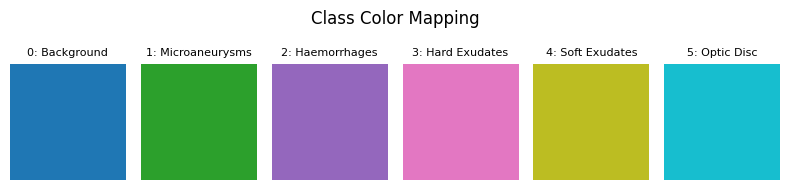

In [23]:
# Update your main execution section:
# Define class names for visualization
CLASS_NAMES = ["Background", "Microaneurysms", "Haemorrhages", "Hard Exudates", "Soft Exudates", "Optic Disc"]

# Show class legend before training
print("Class Color Mapping:")
show_class_legend()

In [24]:
for imgs, masks in train_loader:
    print("Batch images:", imgs.shape)  # (B, 3, H, W)
    print("Batch masks:", masks.shape)  # (B, H, W)
    print("Unique mask labels:", torch.unique(masks))
    break

Batch images: torch.Size([8, 3, 512, 512])
Batch masks: torch.Size([8, 512, 512])
Unique mask labels: tensor([0, 1, 2, 3, 4, 5])


In [25]:
import matplotlib.pyplot as plt
import numpy as np

#Just a visualizer to see how the model performs after epoch
def visualize_predictions(model, dataloader, class_names, num_samples=4):
    model.eval()
    imgs, masks = next(iter(dataloader))  # take one batch
    imgs, masks = imgs.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(imgs)  # (B, C, H, W)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # take class with max logit

    imgs = imgs.cpu().numpy().transpose(0, 2, 3, 1)  # back to (B, H, W, C)
    masks = masks.cpu().numpy()

    plt.figure(figsize=(12, num_samples * 4))
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")

        # Ground truth
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i], cmap="tab20")
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i], cmap="tab20")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [26]:
def debug_predictions(model, dataloader, device):
    """Debug what the model is actually predicting"""
    model.eval()
    imgs, masks = next(iter(dataloader))
    imgs, masks = imgs.to(device), masks.to(device)
    
    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        probabilities = F.softmax(outputs, dim=1)
    
    print("\n🔍 PREDICTION DEBUG:")
    print(f"Output range: [{outputs.min().item():.3f}, {outputs.max().item():.3f}]")
    
    for class_id in range(6):
        class_probs = probabilities[:, class_id]
        class_preds = (preds == class_id).float()
        print(f"Class {class_id}: Avg prob {class_probs.mean().item():.3f}, Pred % {class_preds.mean().item():.3f}")
    
    # Check if any class gets reasonable predictions
    if (preds == 0).float().mean() > 0.95:
        print("🚨 WARNING: Model predicting mostly background!")
    elif preds.float().std() < 0.01:
        print("🚨 WARNING: Model predictions have very low variance!")

# Add this to your training loop
debug_predictions(model, val_loader, device)


🔍 PREDICTION DEBUG:
Output range: [-0.182, 0.164]
Class 0: Avg prob 0.195, Pred % 1.000
Class 1: Avg prob 0.152, Pred % 0.000
Class 2: Avg prob 0.181, Pred % 0.000
Class 3: Avg prob 0.142, Pred % 0.000
Class 4: Avg prob 0.169, Pred % 0.000
Class 5: Avg prob 0.161, Pred % 0.000
🚨 WARNING: Model predicting mostly background!


In [27]:
dummy = torch.randn(1, 3, 256, 256).to(device)
out = model(dummy)

print("Output shape:", out.shape)
print("Unique values in argmax:", torch.unique(out.argmax(dim=1)))

Output shape: torch.Size([1, 6, 256, 256])
Unique values in argmax: tensor([0], device='cuda:0')



🎯 Epoch 1/50
Initial model state:

🔍 PREDICTION DEBUG:
Output range: [-8.672, 9.236]
Class 0: Avg prob 0.953, Pred % 0.965
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.005, Pred % 0.001
Class 3: Avg prob 0.016, Pred % 0.012
Class 4: Avg prob 0.002, Pred % 0.000
Class 5: Avg prob 0.023, Pred % 0.022
🚨 WARNING: Model predicting mostly background!


Per-class IoU: {'MA': '0.000', 'HE': '0.307', 'EX': '0.250', 'SE': '0.025', 'OD': '0.523'}
Avg Gradient Norm: 0.182
📊 Train Loss: 0.0253 | Val Loss: 0.0490
📈 Learning Rate: 1.00e-04
✅ Saved best model | Val Loss: 0.0490

🔍 PREDICTION DEBUG:
Output range: [-9.518, 9.439]
Class 0: Avg prob 0.953, Pred % 0.964
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.003, Pred % 0.001
Class 3: Avg prob 0.017, Pred % 0.014
Class 4: Avg prob 0.002, Pred % 0.000
Class 5: Avg prob 0.022, Pred % 0.022
🚨 WARNING: Model predicting mostly background!

👀 Visualization Epoch 1:


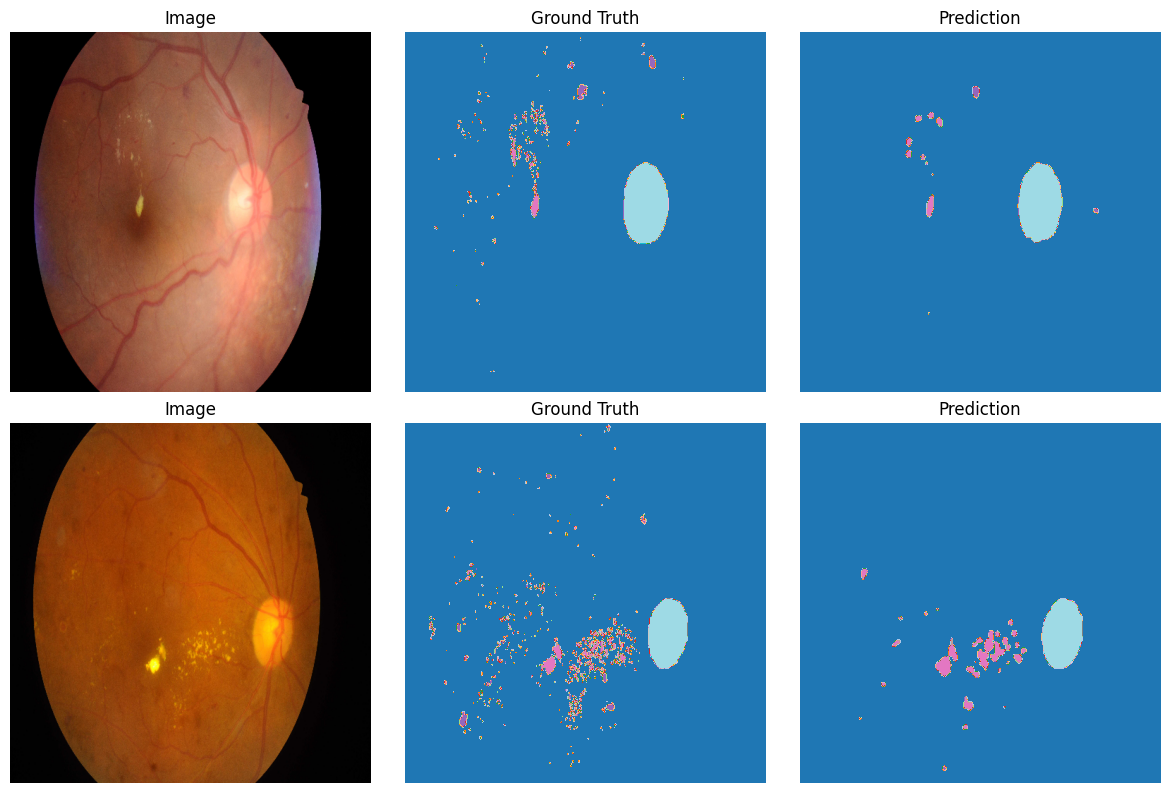


🎯 Epoch 2/50


Per-class IoU: {'MA': '0.000', 'HE': '0.307', 'EX': '0.260', 'SE': '0.056', 'OD': '0.591'}
Avg Gradient Norm: 0.221
📊 Train Loss: 0.0262 | Val Loss: 0.0535
📈 Learning Rate: 1.00e-04

🎯 Epoch 3/50


Per-class IoU: {'MA': '0.000', 'HE': '0.339', 'EX': '0.281', 'SE': '0.097', 'OD': '0.591'}
Avg Gradient Norm: 0.173
📊 Train Loss: 0.0233 | Val Loss: 0.0501
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 3:


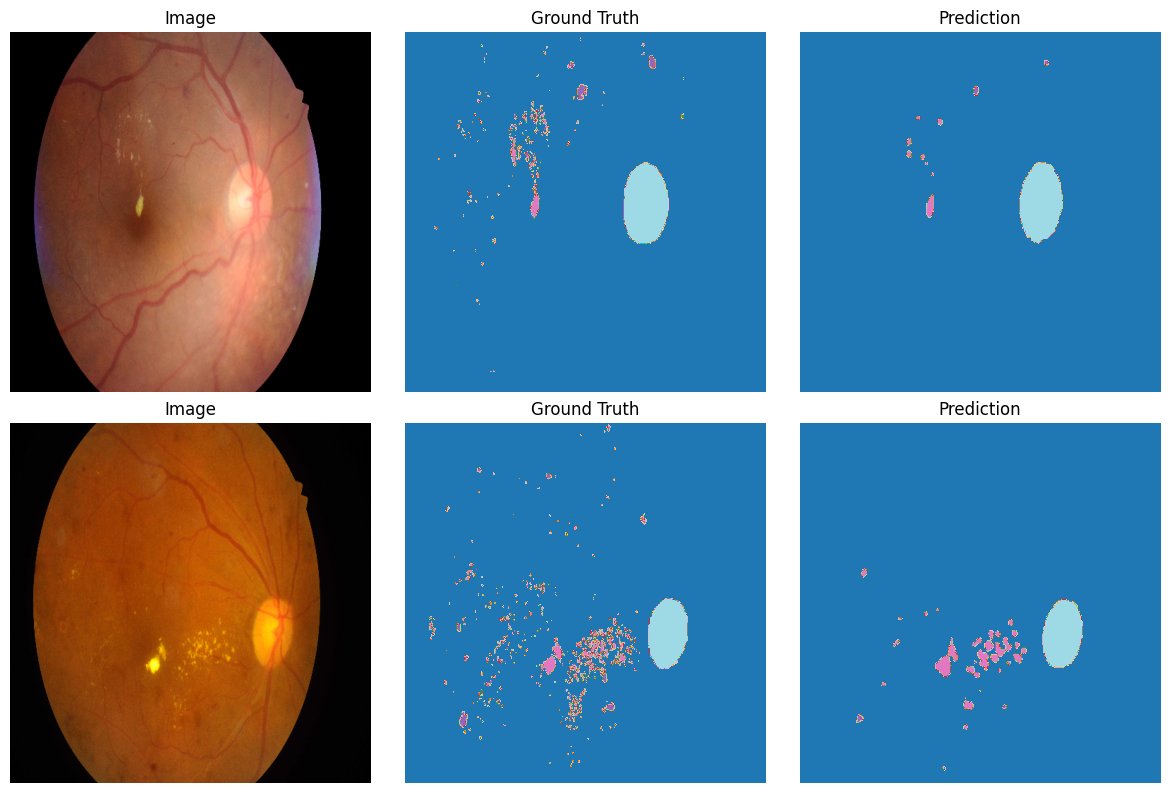


🎯 Epoch 4/50


Per-class IoU: {'MA': '0.000', 'HE': '0.321', 'EX': '0.276', 'SE': '0.148', 'OD': '0.512'}
Avg Gradient Norm: 0.252
📊 Train Loss: 0.0213 | Val Loss: 0.0504
📈 Learning Rate: 1.00e-04

🎯 Epoch 5/50


Per-class IoU: {'MA': '0.000', 'HE': '0.304', 'EX': '0.314', 'SE': '0.129', 'OD': '0.700'}
Avg Gradient Norm: 0.147
📊 Train Loss: 0.0225 | Val Loss: 0.0484
📈 Learning Rate: 1.00e-04
✅ Saved best model | Val Loss: 0.0484

👀 Visualization Epoch 5:


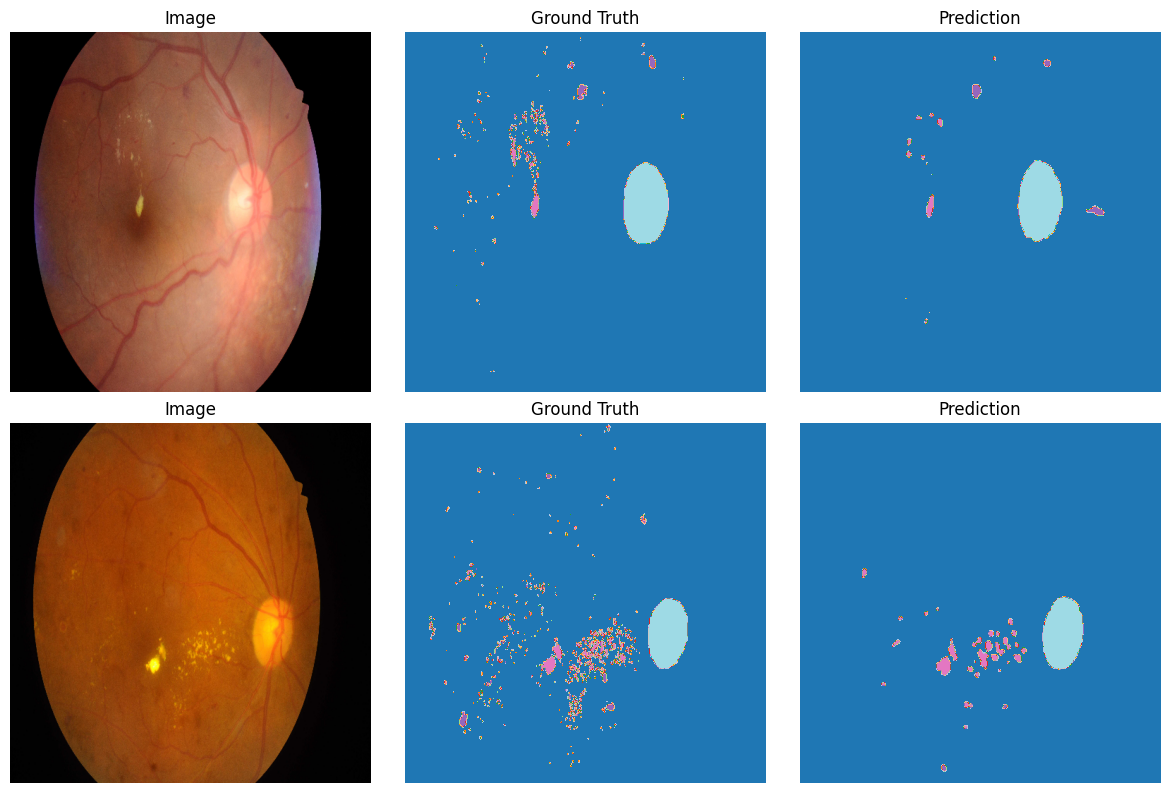


🎯 Epoch 6/50


Per-class IoU: {'MA': '0.000', 'HE': '0.341', 'EX': '0.315', 'SE': '0.143', 'OD': '0.703'}
Avg Gradient Norm: 0.125
📊 Train Loss: 0.0231 | Val Loss: 0.0509
📈 Learning Rate: 1.00e-04

🔍 PREDICTION DEBUG:
Output range: [-11.258, 8.901]
Class 0: Avg prob 0.959, Pred % 0.969
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.004, Pred % 0.001
Class 3: Avg prob 0.015, Pred % 0.012
Class 4: Avg prob 0.002, Pred % 0.000
Class 5: Avg prob 0.018, Pred % 0.018
🚨 WARNING: Model predicting mostly background!

🎯 Epoch 7/50


Per-class IoU: {'MA': '0.000', 'HE': '0.346', 'EX': '0.328', 'SE': '0.261', 'OD': '0.590'}
Avg Gradient Norm: 0.124
📊 Train Loss: 0.0223 | Val Loss: 0.0475
📈 Learning Rate: 1.00e-04
✅ Saved best model | Val Loss: 0.0475

👀 Visualization Epoch 7:


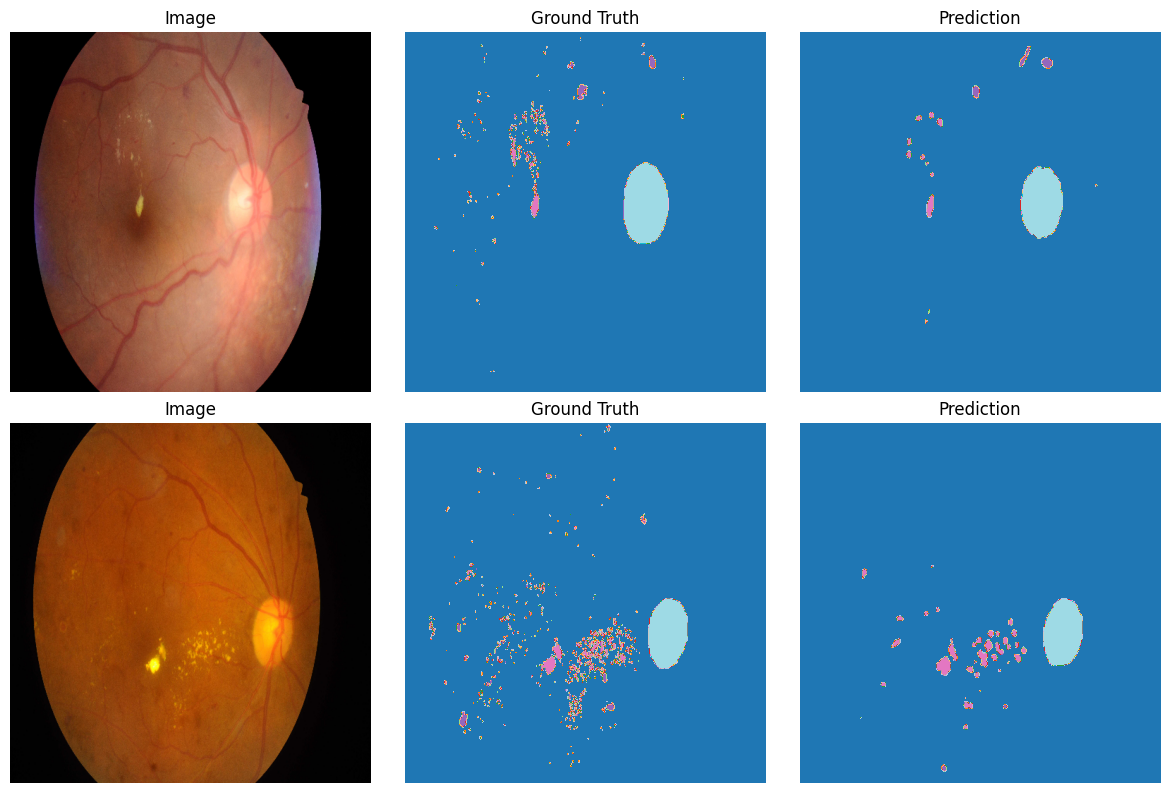


🎯 Epoch 8/50


Per-class IoU: {'MA': '0.000', 'HE': '0.378', 'EX': '0.314', 'SE': '0.315', 'OD': '0.690'}
Avg Gradient Norm: 0.189
📊 Train Loss: 0.0227 | Val Loss: 0.0498
📈 Learning Rate: 1.00e-04

🎯 Epoch 9/50


Per-class IoU: {'MA': '0.000', 'HE': '0.424', 'EX': '0.326', 'SE': '0.319', 'OD': '0.524'}
Avg Gradient Norm: 0.123
📊 Train Loss: 0.0201 | Val Loss: 0.0507
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 9:


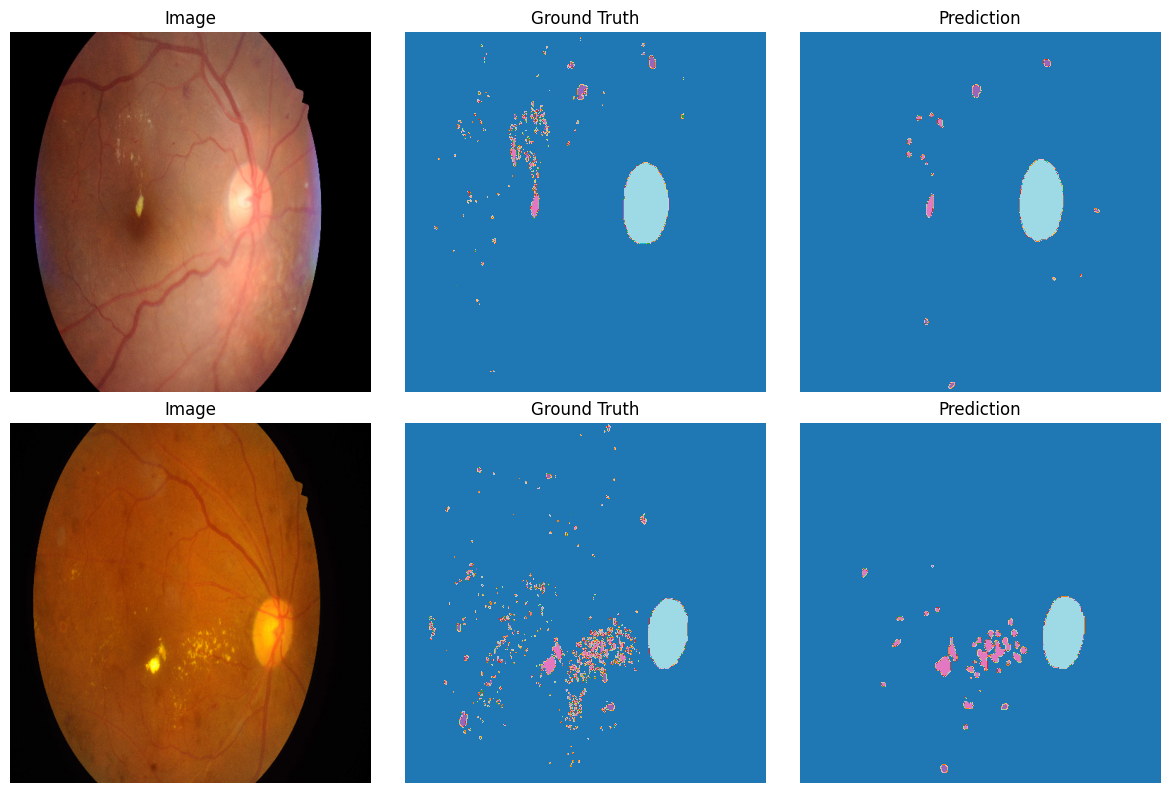


🎯 Epoch 10/50


Per-class IoU: {'MA': '0.000', 'HE': '0.393', 'EX': '0.315', 'SE': '0.315', 'OD': '0.536'}
Avg Gradient Norm: 0.138
📊 Train Loss: 0.0207 | Val Loss: 0.0477
📈 Learning Rate: 1.00e-04

🎯 Epoch 11/50


Per-class IoU: {'MA': '0.000', 'HE': '0.460', 'EX': '0.337', 'SE': '0.316', 'OD': '0.611'}
Avg Gradient Norm: 0.157
📊 Train Loss: 0.0225 | Val Loss: 0.0486
📈 Learning Rate: 1.00e-04

🔍 PREDICTION DEBUG:
Output range: [-11.794, 7.823]
Class 0: Avg prob 0.960, Pred % 0.968
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.003, Pred % 0.001
Class 3: Avg prob 0.014, Pred % 0.012
Class 4: Avg prob 0.002, Pred % 0.000
Class 5: Avg prob 0.020, Pred % 0.020
🚨 WARNING: Model predicting mostly background!

👀 Visualization Epoch 11:


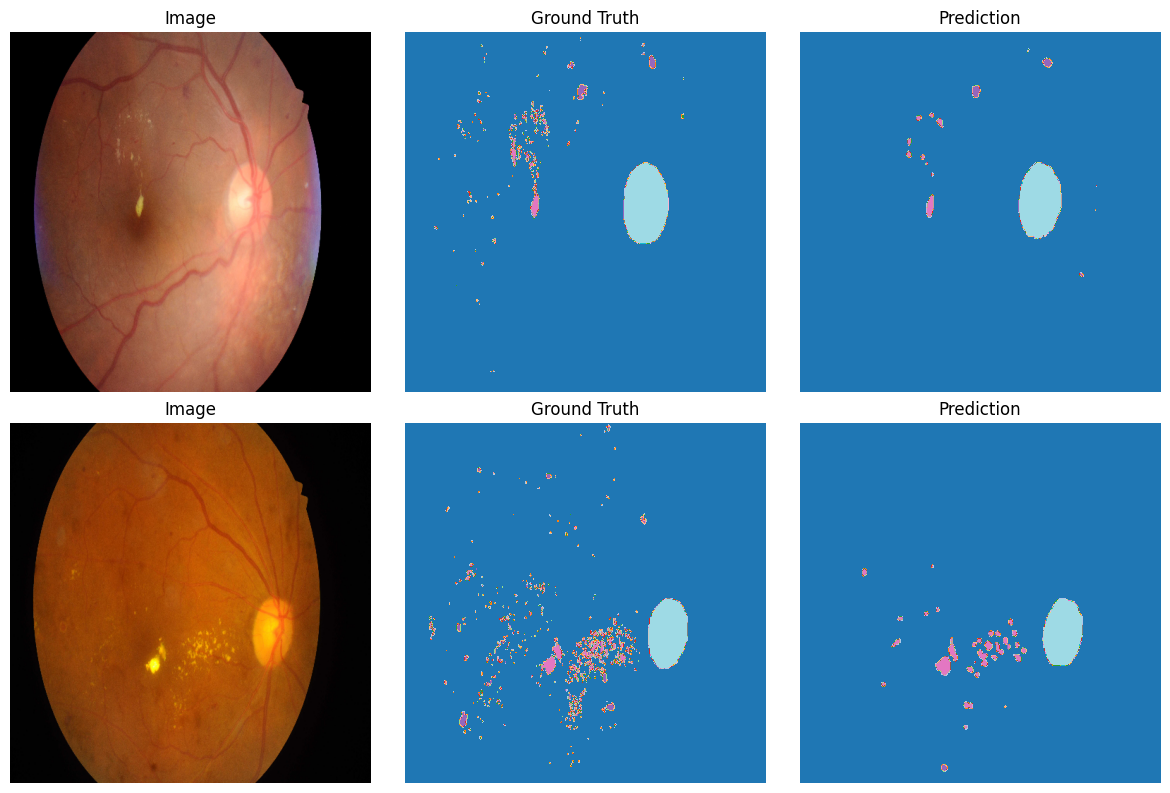


🎯 Epoch 12/50


Per-class IoU: {'MA': '0.000', 'HE': '0.416', 'EX': '0.306', 'SE': '0.349', 'OD': '0.570'}
Avg Gradient Norm: 0.121
📊 Train Loss: 0.0204 | Val Loss: 0.0476
📈 Learning Rate: 1.00e-04

🎯 Epoch 13/50


Per-class IoU: {'MA': '0.000', 'HE': '0.427', 'EX': '0.325', 'SE': '0.400', 'OD': '0.640'}
Avg Gradient Norm: 0.114
📊 Train Loss: 0.0192 | Val Loss: 0.0495
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 13:


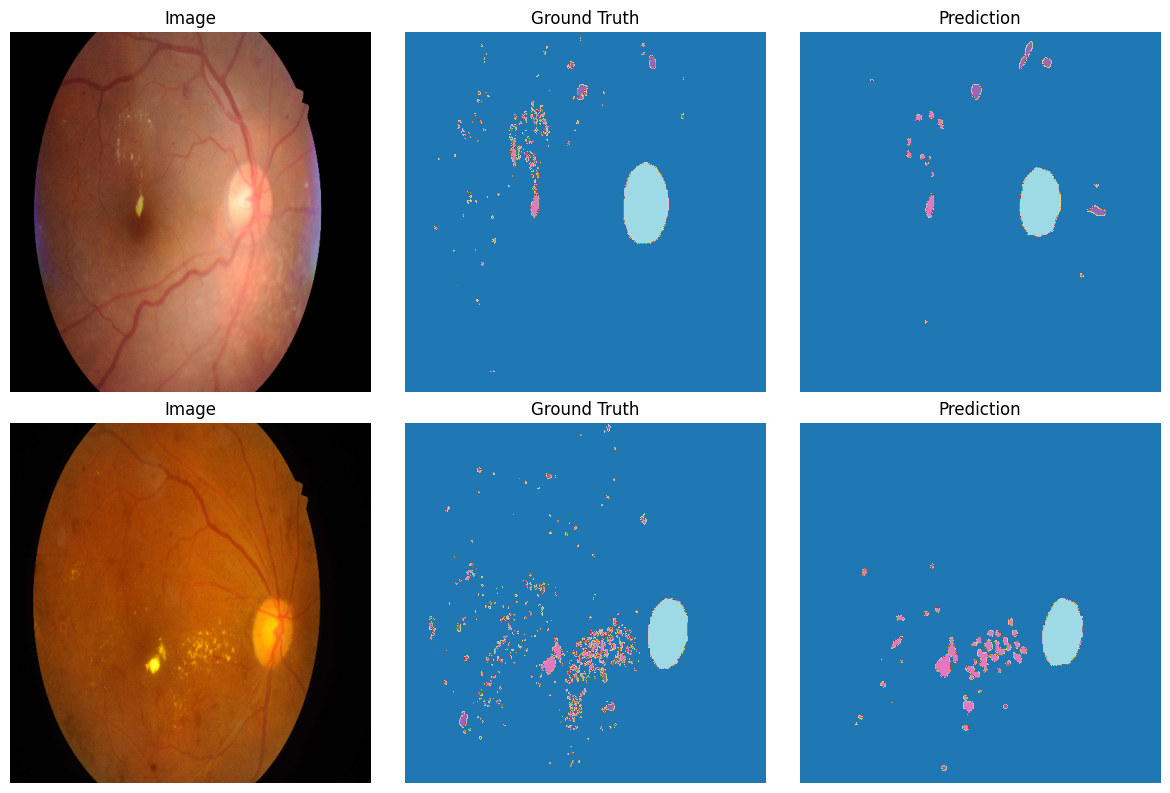


🎯 Epoch 14/50


Per-class IoU: {'MA': '0.000', 'HE': '0.441', 'EX': '0.371', 'SE': '0.425', 'OD': '0.642'}
Avg Gradient Norm: 0.098
📊 Train Loss: 0.0187 | Val Loss: 0.0482
📈 Learning Rate: 1.00e-04

🎯 Epoch 15/50


Per-class IoU: {'MA': '0.000', 'HE': '0.428', 'EX': '0.359', 'SE': '0.396', 'OD': '0.658'}
Avg Gradient Norm: 0.110
📊 Train Loss: 0.0181 | Val Loss: 0.0481
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 15:


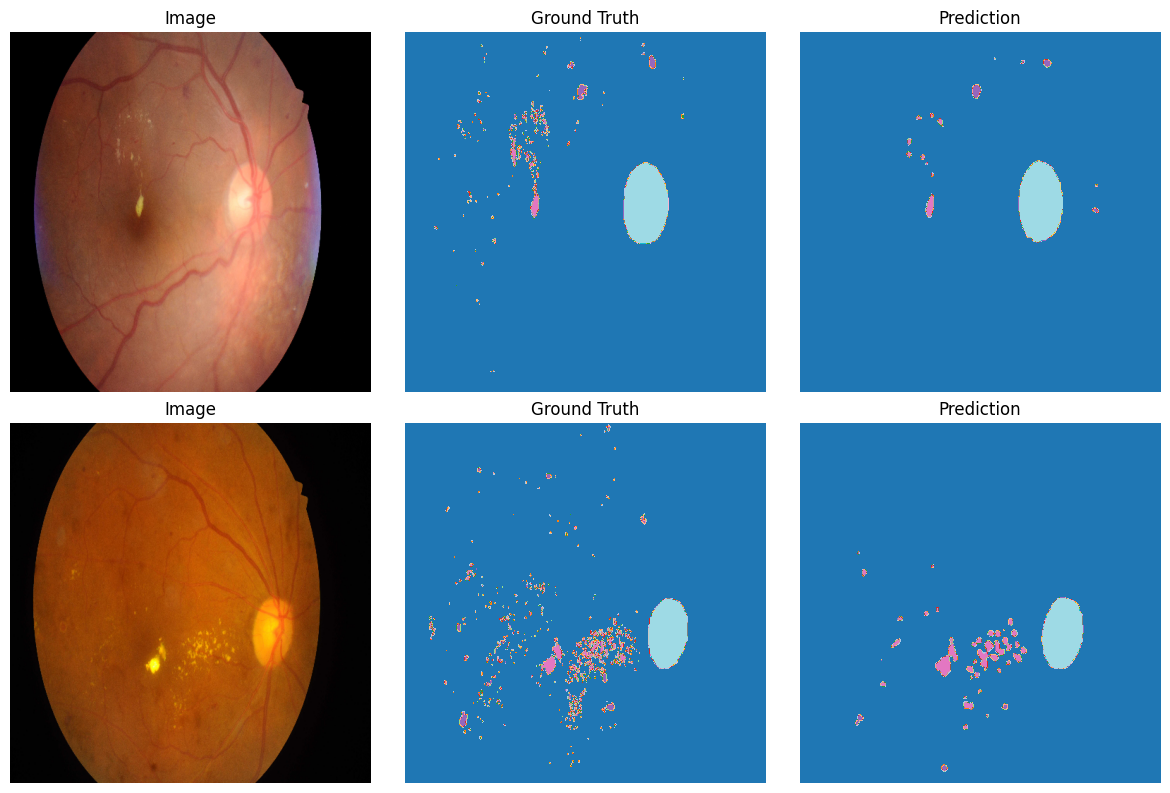


🎯 Epoch 16/50


Per-class IoU: {'MA': '0.000', 'HE': '0.409', 'EX': '0.376', 'SE': '0.442', 'OD': '0.679'}
Avg Gradient Norm: 0.129
📊 Train Loss: 0.0200 | Val Loss: 0.0489
📈 Learning Rate: 1.00e-04

🔍 PREDICTION DEBUG:
Output range: [-11.545, 9.941]
Class 0: Avg prob 0.958, Pred % 0.966
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.005, Pred % 0.002
Class 3: Avg prob 0.013, Pred % 0.010
Class 4: Avg prob 0.002, Pred % 0.000
Class 5: Avg prob 0.022, Pred % 0.022
🚨 WARNING: Model predicting mostly background!

🎯 Epoch 17/50


Per-class IoU: {'MA': '0.000', 'HE': '0.412', 'EX': '0.404', 'SE': '0.495', 'OD': '0.560'}
Avg Gradient Norm: 0.096
📊 Train Loss: 0.0185 | Val Loss: 0.0474
📈 Learning Rate: 1.00e-04
✅ Saved best model | Val Loss: 0.0474

👀 Visualization Epoch 17:


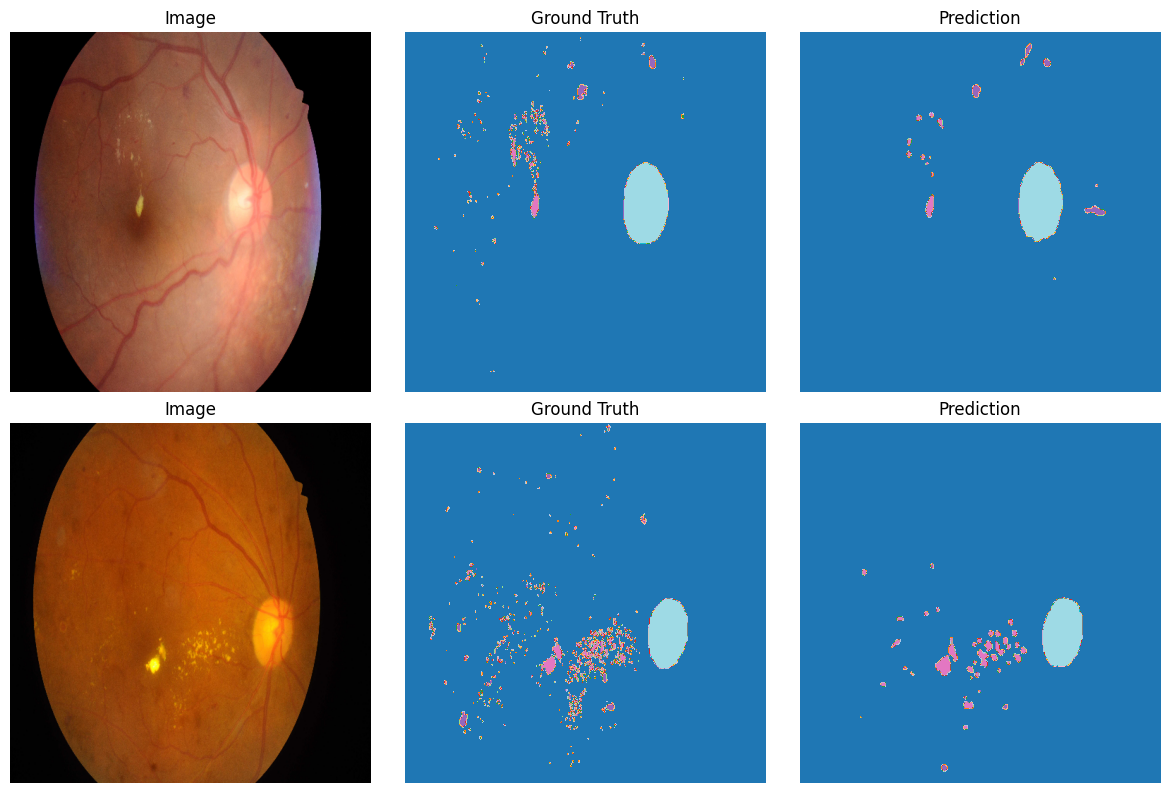


🎯 Epoch 18/50


Per-class IoU: {'MA': '0.000', 'HE': '0.438', 'EX': '0.368', 'SE': '0.421', 'OD': '0.593'}
Avg Gradient Norm: 0.127
📊 Train Loss: 0.0188 | Val Loss: 0.0479
📈 Learning Rate: 1.00e-04

🎯 Epoch 19/50


Per-class IoU: {'MA': '0.000', 'HE': '0.389', 'EX': '0.375', 'SE': '0.418', 'OD': '0.642'}
Avg Gradient Norm: 0.405
📊 Train Loss: 0.0214 | Val Loss: 0.0503
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 19:


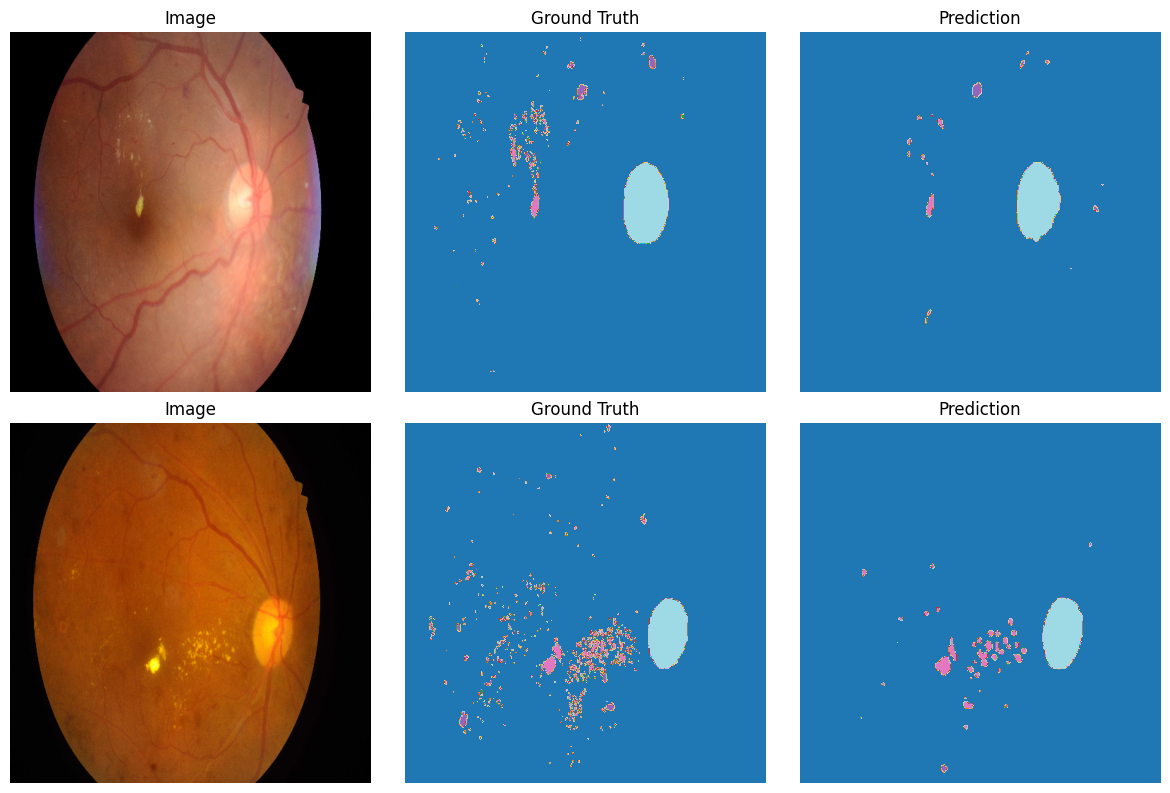


🎯 Epoch 20/50


Per-class IoU: {'MA': '0.000', 'HE': '0.391', 'EX': '0.352', 'SE': '0.440', 'OD': '0.663'}
Avg Gradient Norm: 0.118
📊 Train Loss: 0.0197 | Val Loss: 0.0488
📈 Learning Rate: 1.00e-04

🎯 Epoch 21/50


Per-class IoU: {'MA': '0.000', 'HE': '0.395', 'EX': '0.390', 'SE': '0.442', 'OD': '0.572'}
Avg Gradient Norm: 0.117
📊 Train Loss: 0.0176 | Val Loss: 0.0497
📈 Learning Rate: 1.00e-04

🔍 PREDICTION DEBUG:
Output range: [-13.326, 8.942]
Class 0: Avg prob 0.958, Pred % 0.967
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.007, Pred % 0.002
Class 3: Avg prob 0.013, Pred % 0.010
Class 4: Avg prob 0.001, Pred % 0.000
Class 5: Avg prob 0.021, Pred % 0.020
🚨 WARNING: Model predicting mostly background!

👀 Visualization Epoch 21:


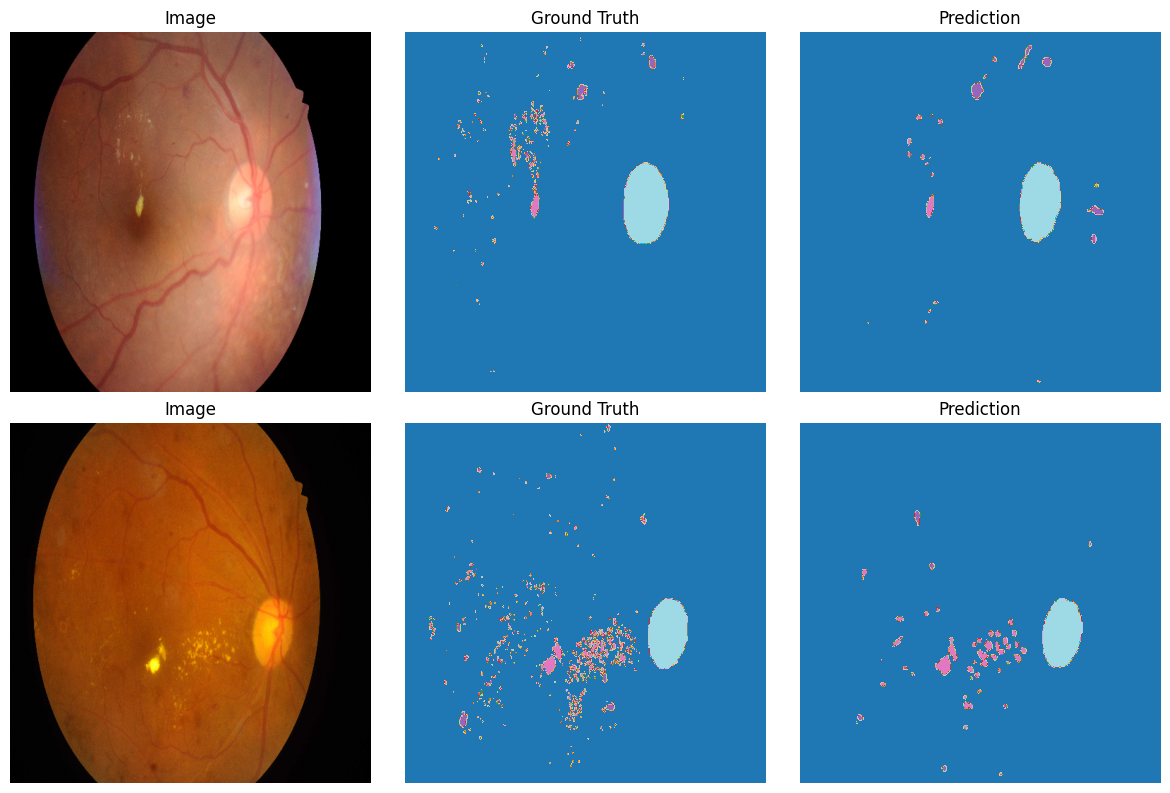


🎯 Epoch 22/50


Per-class IoU: {'MA': '0.000', 'HE': '0.382', 'EX': '0.373', 'SE': '0.493', 'OD': '0.663'}
Avg Gradient Norm: 0.098
📊 Train Loss: 0.0173 | Val Loss: 0.0485
📈 Learning Rate: 1.00e-04

🎯 Epoch 23/50


Per-class IoU: {'MA': '0.000', 'HE': '0.475', 'EX': '0.403', 'SE': '0.500', 'OD': '0.680'}
Avg Gradient Norm: 0.124
📊 Train Loss: 0.0185 | Val Loss: 0.0477
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 23:


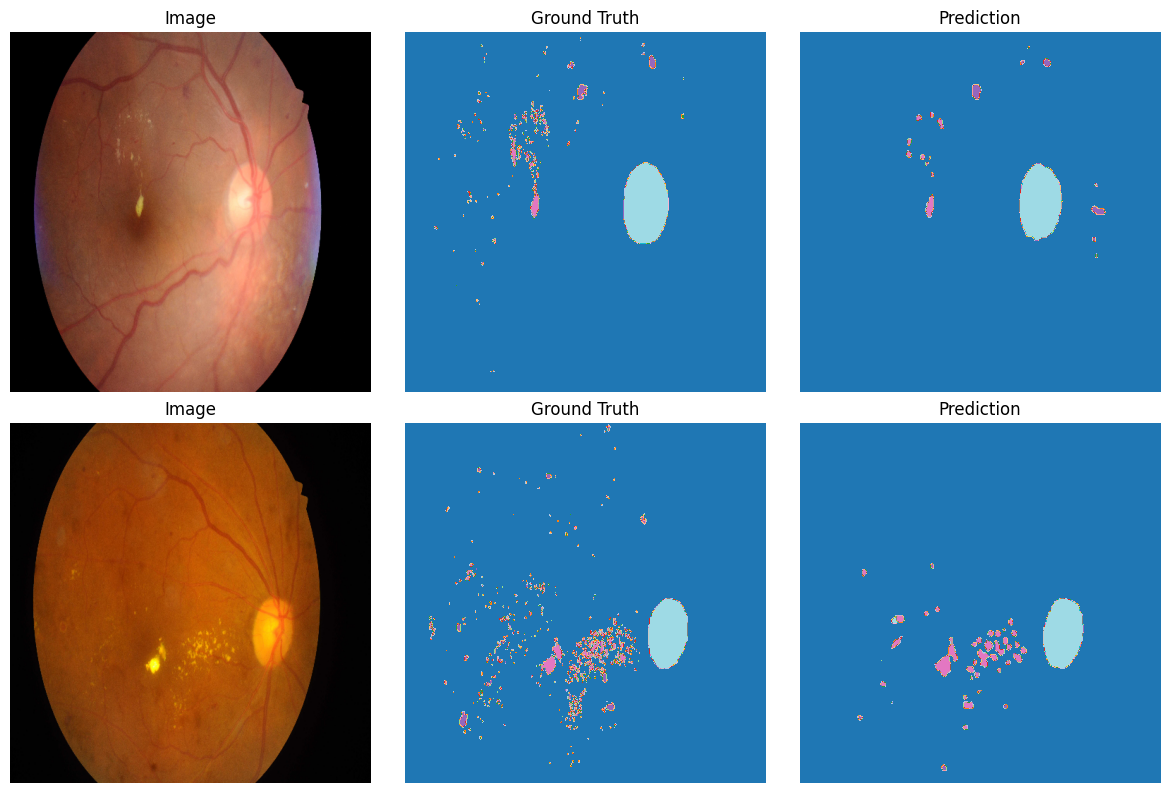


🎯 Epoch 24/50


Per-class IoU: {'MA': '0.000', 'HE': '0.413', 'EX': '0.381', 'SE': '0.543', 'OD': '0.566'}
Avg Gradient Norm: 0.072
📊 Train Loss: 0.0156 | Val Loss: 0.0480
📈 Learning Rate: 1.00e-04

🎯 Epoch 25/50


Per-class IoU: {'MA': '0.000', 'HE': '0.487', 'EX': '0.383', 'SE': '0.584', 'OD': '0.703'}
Avg Gradient Norm: 0.079
📊 Train Loss: 0.0175 | Val Loss: 0.0477
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 25:


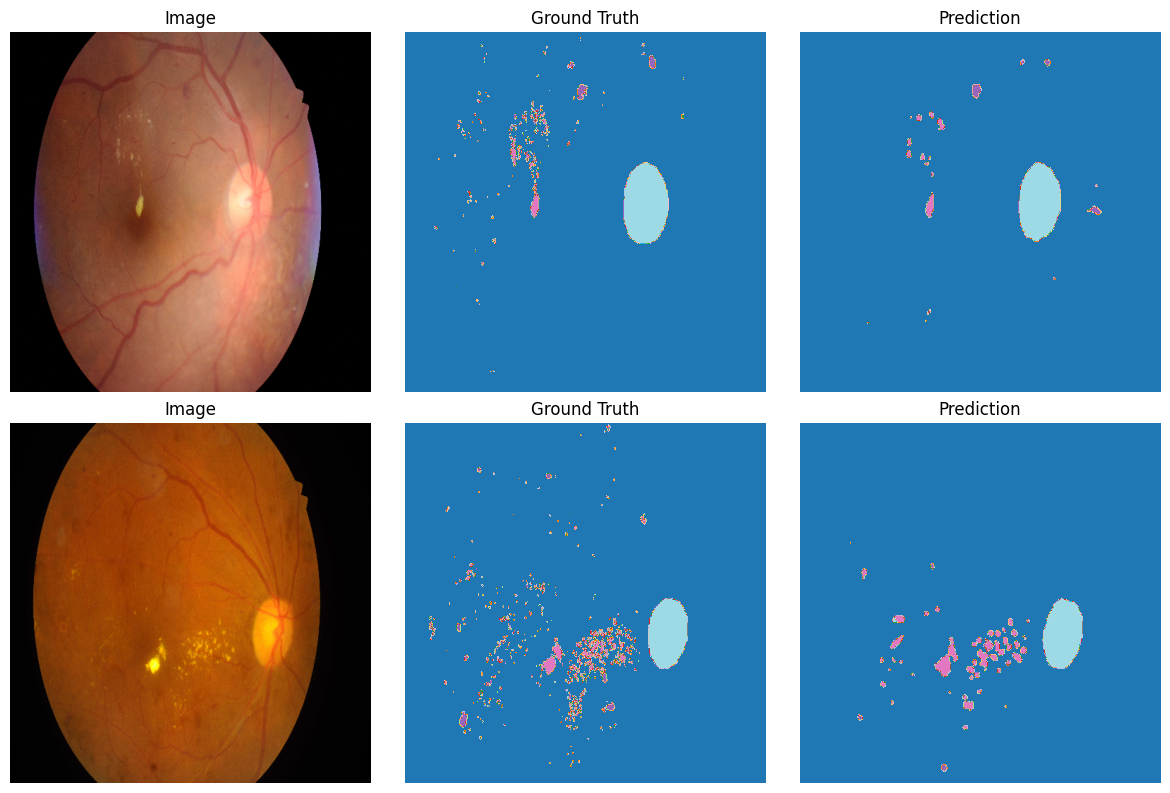


🎯 Epoch 26/50


Per-class IoU: {'MA': '0.000', 'HE': '0.478', 'EX': '0.425', 'SE': '0.553', 'OD': '0.684'}
Avg Gradient Norm: 0.101
📊 Train Loss: 0.0180 | Val Loss: 0.0497
📈 Learning Rate: 1.00e-04

🔍 PREDICTION DEBUG:
Output range: [-13.797, 7.928]
Class 0: Avg prob 0.961, Pred % 0.968
Class 1: Avg prob 0.000, Pred % 0.000
Class 2: Avg prob 0.002, Pred % 0.001
Class 3: Avg prob 0.015, Pred % 0.012
Class 4: Avg prob 0.001, Pred % 0.000
Class 5: Avg prob 0.019, Pred % 0.019
🚨 WARNING: Model predicting mostly background!

🎯 Epoch 27/50


Per-class IoU: {'MA': '0.000', 'HE': '0.540', 'EX': '0.394', 'SE': '0.574', 'OD': '0.578'}
Avg Gradient Norm: 0.083
📊 Train Loss: 0.0165 | Val Loss: 0.0496
📈 Learning Rate: 1.00e-04

👀 Visualization Epoch 27:


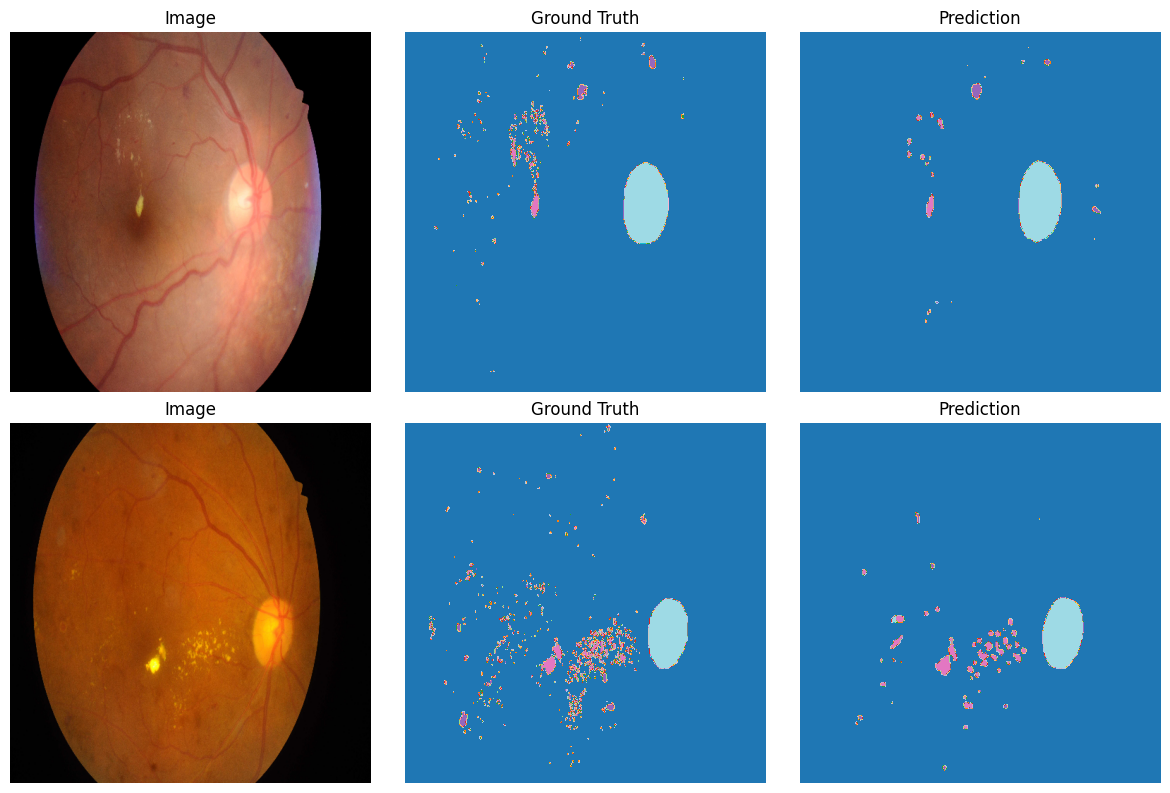


🎯 Epoch 28/50


Per-class IoU: {'MA': '0.000', 'HE': '0.500', 'EX': '0.399', 'SE': '0.542', 'OD': '0.725'}
Avg Gradient Norm: 0.080
📊 Train Loss: 0.0164 | Val Loss: 0.0481
📈 Learning Rate: 5.00e-05

🎯 Epoch 29/50


Per-class IoU: {'MA': '0.000', 'HE': '0.557', 'EX': '0.395', 'SE': '0.593', 'OD': '0.624'}
Avg Gradient Norm: 0.070
📊 Train Loss: 0.0156 | Val Loss: 0.0477
📈 Learning Rate: 5.00e-05

👀 Visualization Epoch 29:


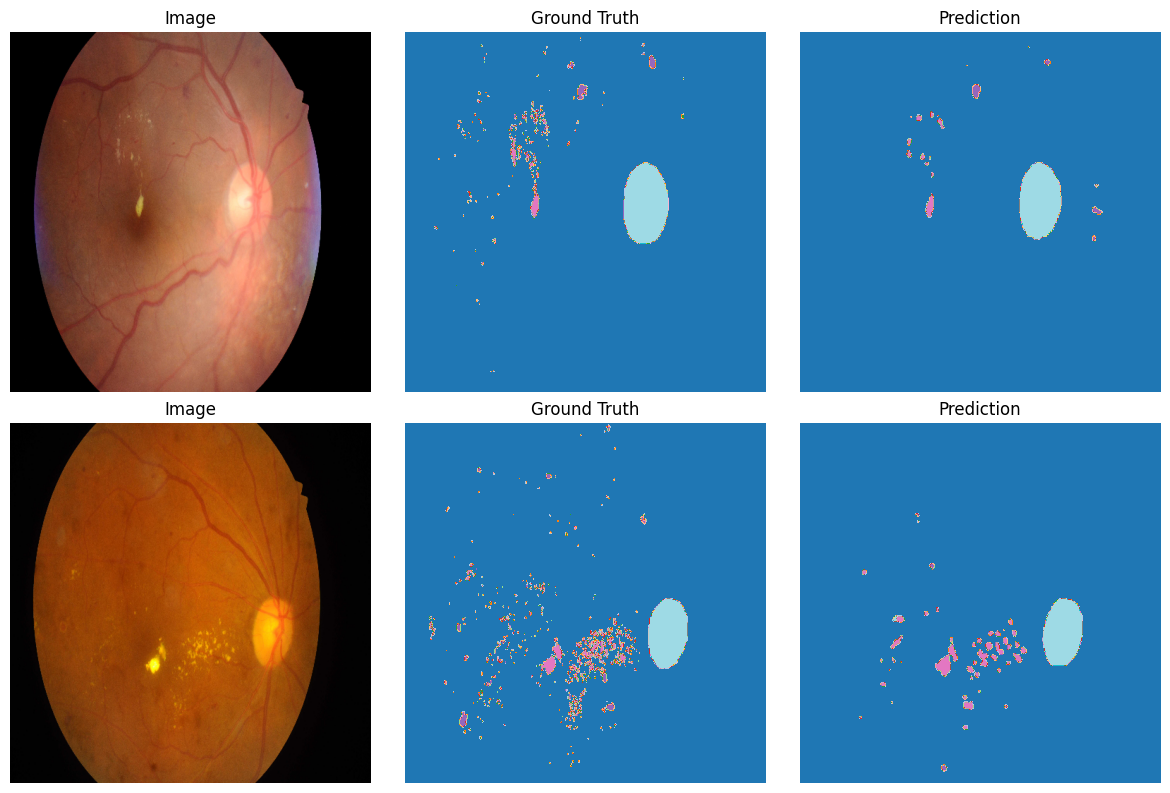


🎯 Epoch 30/50


Per-class IoU: {'MA': '0.000', 'HE': '0.489', 'EX': '0.387', 'SE': '0.663', 'OD': '0.590'}
Avg Gradient Norm: 0.055
📊 Train Loss: 0.0135 | Val Loss: 0.0484
📈 Learning Rate: 5.00e-05

🎯 Epoch 31/50


Per-class IoU: {'MA': '0.000', 'HE': '0.475', 'EX': '0.444', 'SE': '0.621', 'OD': '0.712'}
Avg Gradient Norm: 0.070
📊 Train Loss: 0.0152 | Val Loss: 0.0495
📈 Learning Rate: 5.00e-05

🔍 PREDICTION DEBUG:
Output range: [-12.634, 8.877]
Class 0: Avg prob 0.960, Pred % 0.967
Class 1: Avg prob 0.001, Pred % 0.000
Class 2: Avg prob 0.003, Pred % 0.001
Class 3: Avg prob 0.013, Pred % 0.011
Class 4: Avg prob 0.001, Pred % 0.000
Class 5: Avg prob 0.021, Pred % 0.021
🚨 WARNING: Model predicting mostly background!

👀 Visualization Epoch 31:


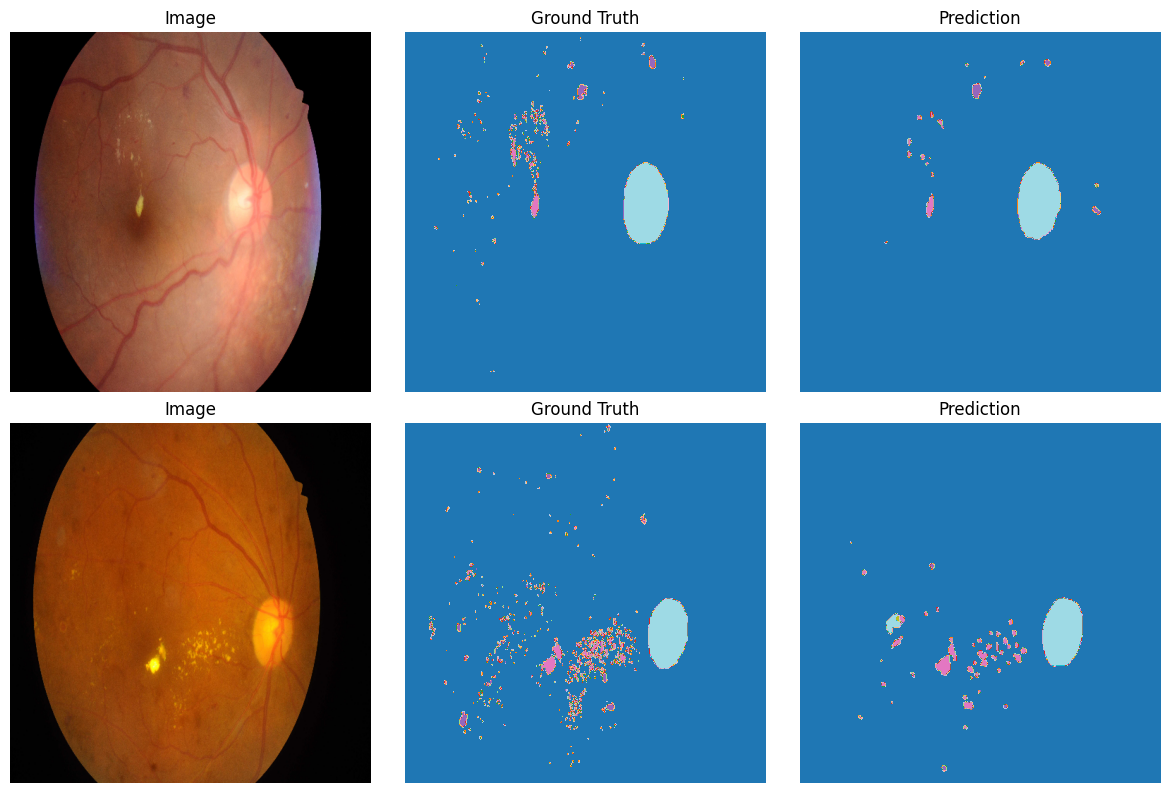


🎯 Epoch 32/50


Per-class IoU: {'MA': '0.000', 'HE': '0.534', 'EX': '0.399', 'SE': '0.578', 'OD': '0.624'}
Avg Gradient Norm: 0.072
📊 Train Loss: 0.0153 | Val Loss: 0.0496
📈 Learning Rate: 5.00e-05

🎯 Epoch 33/50


Per-class IoU: {'MA': '0.000', 'HE': '0.537', 'EX': '0.425', 'SE': '0.621', 'OD': '0.692'}
Avg Gradient Norm: 0.072
📊 Train Loss: 0.0142 | Val Loss: 0.0482
📈 Learning Rate: 5.00e-05

👀 Visualization Epoch 33:


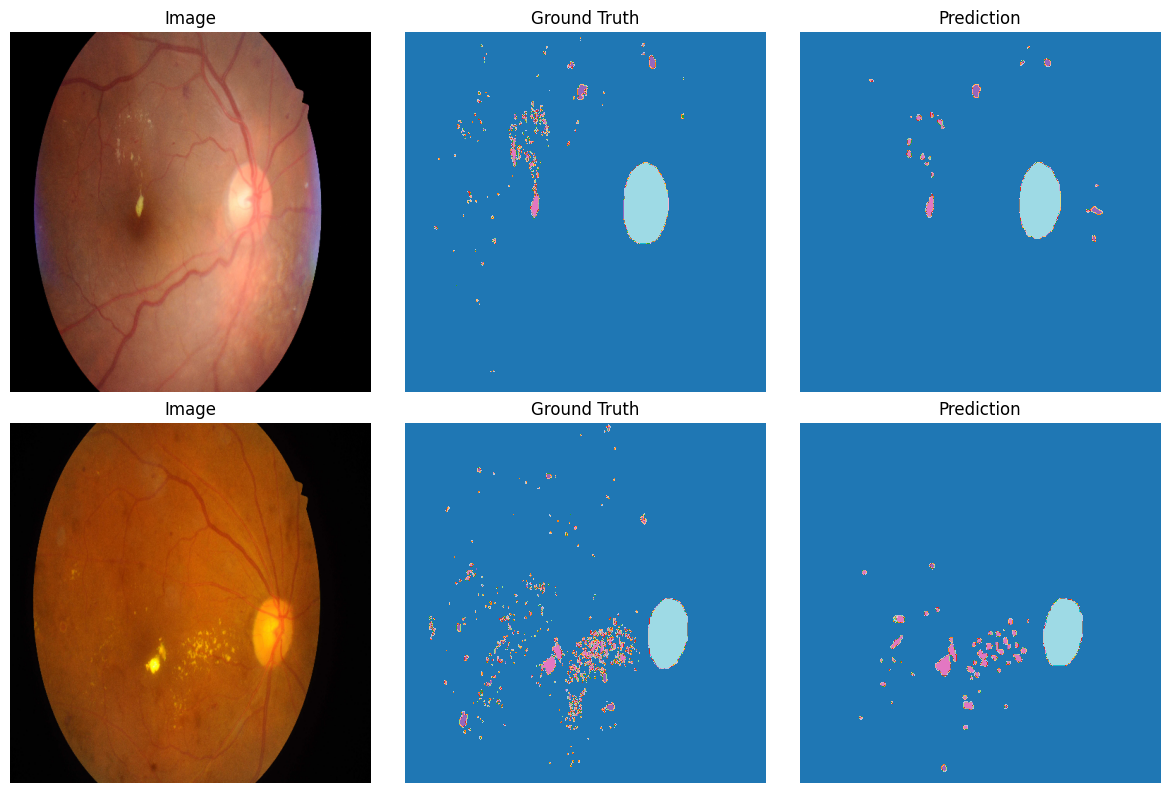


🎯 Epoch 34/50


Training (Grad: 0.04):  31%|███       | 17/55 [00:18<00:41,  1.08s/it, loss=0.00653]

In [ ]:
def train_model_fixed(model, train_loader, val_loader, epochs, device, class_names):
    # Start simple
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        print(f"\n🎯 Epoch {epoch+1}/{epochs}")
        print("=" * 60)
        
        # Debug before training
        if epoch == 0:
            print("Initial model state:")
            debug_predictions(model, val_loader, device)
        
        # Train
        train_loss = train_one_epoch_with_gradient_control(
            model, train_loader, optimizer, criterion, device, 
            max_grad_norm=1.0
        )
        
        # Validate
        val_loss = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        
        print(f"📊 Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"📈 Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "cmac_best.pth")
            print(f"✅ Saved best model | Val Loss: {val_loss:.4f}")
        
        # Debug predictions every few epochs
        if epoch % 5 == 0:
            debug_predictions(model, val_loader, device)
        
        # Visualize
        if epoch % 2 == 0:
            print(f"\n👀 Visualization Epoch {epoch+1}:")
            visualize_predictions(model, val_loader, class_names, num_samples=2)
        
        # If no progress after 10 epochs, try different approach
        if epoch > 10 and best_val_loss > 2.0:  # If loss is still very high
            print("🔄 No significant progress, trying weighted loss...")
            real_weights = calculate_class_weights_from_data(train_dataset)
            criterion = nn.CrossEntropyLoss(weight=real_weights.to(device))
state_dict = torch.load('/kaggle/input/cmac-net/pytorch/default/1/cmac_best.pth')
model.load_state_dict(state_dict)
train_model_fixed(model, train_loader, val_loader, epochs=50, device=device, class_names=CLASS_NAMES)

In [ ]:
# Save
torch.save(model.state_dict(), "CMACNet_weights.pth")